# Problem Statements
- As an employee of ETDD, I am tasked to predict Singapore's electricity demand. 

- This study focuses on predicting the peak electricity demand, which is the highest instantaneous demand, of Singapore for one-year ahead. 

- Peak demand is important as we need to make sure that there is sufficient electricity infrastructure (e.g. generation plants, transmission and distribution network) in place to meet Singapore's demand at any point in time. This information will be useful to advise decision makers on the amount of infrastructure required.

# Dataset
- Half-hourly System Demand (MW) from 1 Jan 2003 - 18 Apr 2022 
(Source: EMC, Uniform Singapore Energy Price (USEP) and Demand Forecast,  https://www.emcsg.com/marketdata/priceinformation)
- GDP in Chained (2015) Dollars from 1Q 2003 - 4Q 2021 (Source: Singapore Department of Statistics, https://www.singstat.gov.sg/find-data/search-by-theme/economy/national-accounts/latest-data)



# Load Libraries

In [168]:
# !pip3 install scipy statsmodels
# !pip install openpyxl

In [1]:
import datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Load Data

### Uniform Singapore Energy Price (USEP) data

In [98]:
# merge usep's Apr 2016 data which was split into two from source
usep_apr2016_1 = pd.read_csv("../data/USEP_01-Apr-2016_to_27-Apr-2016.csv")
usep_apr2016_2 = pd.read_csv("../data/USEP_28-Apr-2016_to_30-Apr-2016.csv")
usep_apr2016 = pd.concat([usep_apr2016_1, usep_apr2016_2], ignore_index=True)
usep_apr2016.to_csv('../data/USEP_Apr-2016.csv', index=False)

In [99]:
# concat usep data for 2003-2021 (full year)
usep = pd.DataFrame()
for year in range(2003, 2022):
    for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        usep_temp = pd.read_csv(f"../data/USEP_{month}-{year}.csv")
        usep = pd.concat([usep, usep_temp], ignore_index=True)

In [100]:
# concat usep data with 2022 (Jan-Apr)
for year in ['2022']:
    for month in ['Jan', 'Feb', 'Mar', 'Apr']:
        usep_temp = pd.read_csv(f"../data/USEP_{month}-{year}.csv")
        usep = pd.concat([usep, usep_temp], ignore_index=True)

In [101]:
# export a copy of combined usep data
usep.to_csv('../data/usep_2003_apr2022.csv', index=False)

In [102]:
# Create a function to rename columns
def columns_rename(columns):
    """ Rename column names to lower case with underscore between words"""
    return columns.lower().replace(' ', '_').replace('(', '').replace(')', '')

usep.columns = [columns_rename(col) for col in usep.columns]

In [103]:
# Create a function to convert 48 half-hourly periods to time
def to_time(period):
    hour = (period-1)//2
    minute = (period%2-1)*-30
    seconds = 0
    # time = datetime.time(hour, minute, seconds)
    return f"{hour}:{minute}:{seconds}"
        
usep['time'] = usep['period'].map(lambda period: to_time(period))

In [104]:
# str date and time and convert datetime to datetime format
usep['datetime'] = pd.to_datetime(usep['date'] + ' ' + usep['time'])
usep['datetime'] = pd.to_datetime(usep['datetime'])

In [105]:
# convert date to datetime format
usep['date'] = pd.to_datetime(usep['date'])

In [106]:
usep.head()

,price_type,date,period,price_$/mwh,demand_mw,information_type,usep_$/mwh,lcp_$/mwh,tcl_mw,time,datetime
0,USEP,2003-01-01,1,67.28,3268.933,NaN,NaN,NaN,NaN,0:0:0,2003-01-01 00:00:00
1,USEP,2003-01-01,2,67.20,3208.756,NaN,NaN,NaN,NaN,0:30:0,2003-01-01 00:30:00
2,USEP,2003-01-01,3,61.32,3143.460,NaN,NaN,NaN,NaN,1:0:0,2003-01-01 01:00:00
3,USEP,2003-01-01,4,56.23,3087.796,NaN,NaN,NaN,NaN,1:30:0,2003-01-01 01:30:00
4,USEP,2003-01-01,5,56.04,3042.699,NaN,NaN,NaN,NaN,2:0:0,2003-01-01 02:00:00


### Covid Phase and % WFH data

In [107]:
# load covid data with info on % WFH by date
covid = pd.read_excel("../data/MAP_DATE_DAYTYPE_COVIDPHASE.xlsx", sheet_name = "28Apr2022")

In [108]:
# rename columns
covid.columns = [columns_rename(col) for col in covid.columns]

In [109]:
covid.head()

,date,day_type,holiday,covid_phase,wfh_indicator
0,2019-01-01,PH,New Year's Day,Pre-CB,0
1,2019-01-02,Weekday,NaN,Pre-CB,0
2,2019-01-03,Weekday,NaN,Pre-CB,0
3,2019-01-04,Weekday,NaN,Pre-CB,0
4,2019-01-05,Weekend,NaN,Pre-CB,0


In [110]:
# merge usep with covid data
usep = pd.merge(left = usep, 
         right = covid, 
         how = "left",
         left_on = "date",
        right_on = "date")

In [111]:
# impute missing covid_phase with 'Pre-CB' for 2003-2018 as covid data only has data from 2019-2022
usep.loc[usep['covid_phase'].isnull() & (usep['date'] < pd.to_datetime('2019-01-01')), 'covid_phase'] = 'Pre-CB'

# impute missing entry for 2021-01-29 based on covid_phase for 2021-01-28 and 2021-01-30 which is 'Phase 3'
usep.loc[usep['covid_phase'].isnull() & (usep['date'] == pd.to_datetime('2021-01-29')), 'covid_phase'] = 'Phase 3'

In [112]:
# impute missing wfh_indicator with 0 for 2003-2018 as covid data only has data from 2019-2022
usep.loc[(usep['wfh_indicator'].isnull())  & (usep['date'] < pd.to_datetime('2019-01-01')), 'wfh_indicator'] = 0

# impute missing entry for 2021-01-29 based on wfh_indicator for 2021-01-28 and 2021-01-30 which is 50
usep.loc[usep['wfh_indicator'].isnull() & (usep['date'] == pd.to_datetime('2021-01-29')), 'wfh_indicator'] = 50

In [113]:
# weekdays as a tuple
weekdays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")

# create dayofweek to indicate the day of week
usep['dayofweek'] = usep['date'].apply(lambda date: date.weekday())
usep['dayofweek'] = usep['dayofweek'].apply(lambda day: weekdays[day])

In [114]:
# create a column is_ph based on whether a holiday name is 
usep['is_ph'] = usep['holiday'].map(lambda holiday: 0 if str(holiday) == "nan" else 1)

In [115]:
usep.head()

,price_type,date,period,price_$/mwh,demand_mw,information_type,usep_$/mwh,lcp_$/mwh,tcl_mw,time,datetime,day_type,holiday,covid_phase,wfh_indicator,dayofweek,is_ph
0,USEP,2003-01-01,1,67.28,3268.933,NaN,NaN,NaN,NaN,0:0:0,2003-01-01 00:00:00,NaN,NaN,Pre-CB,0.0,Wednesday,0
1,USEP,2003-01-01,2,67.20,3208.756,NaN,NaN,NaN,NaN,0:30:0,2003-01-01 00:30:00,NaN,NaN,Pre-CB,0.0,Wednesday,0
2,USEP,2003-01-01,3,61.32,3143.460,NaN,NaN,NaN,NaN,1:0:0,2003-01-01 01:00:00,NaN,NaN,Pre-CB,0.0,Wednesday,0
3,USEP,2003-01-01,4,56.23,3087.796,NaN,NaN,NaN,NaN,1:30:0,2003-01-01 01:30:00,NaN,NaN,Pre-CB,0.0,Wednesday,0
4,USEP,2003-01-01,5,56.04,3042.699,NaN,NaN,NaN,NaN,2:0:0,2003-01-01 02:00:00,NaN,NaN,Pre-CB,0.0,Wednesday,0


### GDP

In [116]:
# load covid data with info on % WFH by date
gdp = pd.read_csv("../data/gdp.csv")

In [117]:
# slice data to the relevant rows and columns
gdp = gdp.iloc[9:11,].T.iloc[1:]

In [118]:
# rename columns
gdp = gdp.rename(columns={
    9: "date", 
    10: "gdp"
}).reset_index()

In [119]:
# drop irrelevant columns
gdp.drop("index", axis=1, inplace=True)

In [120]:
# add a row for 1Q-4Q2022
NaN = float("NaN")
gdp.loc[-1] = ["2022 1Q", NaN]
gdp.loc[-2] = ["2022 2Q", NaN]
gdp.loc[-3] = ["2022 3Q", NaN]
gdp.loc[-4] = ["2022 4Q", NaN]
gdp.index = gdp.index + 4
gdp = gdp.sort_index()

In [121]:
# convert gdp to float
gdp['gdp'] = gdp['gdp'].astype(float)

In [122]:
# create gdp with 1 quarter lag
gdp['gdp_lag_4q'] = gdp['gdp'].shift(-4)
gdp

,date,gdp,gdp_lag_4q
0,2022 4Q,NaN,126836.0
1,2022 3Q,NaN,123989.5
2,2022 2Q,NaN,122163.7
3,2022 1Q,NaN,123152.1
4,2021 4Q,126836.0,119592.3
...,...,...,...
187,1976 1Q,8169.7,7546.0
188,1975 4Q,7948.1,NaN
189,1975 3Q,7836.6,NaN
190,1975 2Q,7681.5,NaN


In [123]:
# create year and quarter columns
gdp['year'] = gdp['date'].str[:5]
gdp['quarter'] = gdp['date'].str[5]

gdp['year'] = pd.to_numeric(gdp['year'])
gdp['quarter'] = pd.to_numeric(gdp['quarter'])

In [124]:
# create year and quarter columns in usep data as well for merging of datasets
usep['year'] = usep['date'].dt.year
usep['quarter'] = usep['date'].dt.quarter

In [125]:
# merge usep with gdp data
usep = pd.merge(left = usep, 
         right = gdp, 
         how = "left",
         left_on = ['year', 'quarter'],
        right_on = ['year', 'quarter'])

In [126]:
# Drop date columns and other columns which we will not be using
usep.drop(columns=['date_x', 'date_y', 'time', 'quarter',
                   'price_type', 'price_$/mwh', 'information_type', 
                   'usep_$/mwh', 'lcp_$/mwh', 'tcl_mw', 
                   'day_type', 'holiday'], 
          inplace=True)

In [127]:
# Set index to be the date column as a DatetimeIndex.
usep.set_index(usep['datetime'], inplace=True)

In [128]:
# Drop datetime column
usep.drop(columns=['datetime'], 
          inplace=True)

In [129]:
usep.head()

,period,demand_mw,covid_phase,wfh_indicator,dayofweek,is_ph,year,gdp,gdp_lag_4q
datetime,,,,,,,,,
2003-01-01 00:00:00,1,3268.933,Pre-CB,0.0,Wednesday,0,2003,50602.0,48589.8
2003-01-01 00:30:00,2,3208.756,Pre-CB,0.0,Wednesday,0,2003,50602.0,48589.8
2003-01-01 01:00:00,3,3143.460,Pre-CB,0.0,Wednesday,0,2003,50602.0,48589.8
2003-01-01 01:30:00,4,3087.796,Pre-CB,0.0,Wednesday,0,2003,50602.0,48589.8
2003-01-01 02:00:00,5,3042.699,Pre-CB,0.0,Wednesday,0,2003,50602.0,48589.8


# EDA & Feature Engineering

In [38]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

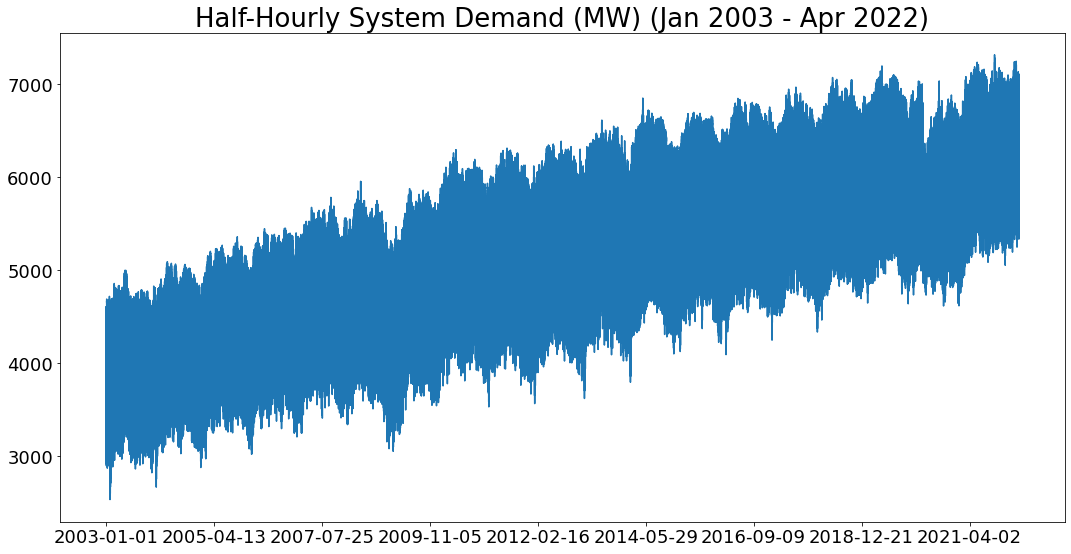

In [39]:
# Generate a time plot of our data.
plot_series(usep, ['demand_mw'], title = "Half-Hourly System Demand (MW) (Jan 2003 - Apr 2022)", steps=40000)

In [40]:
# Code written by Joseph Nelson
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [209]:
# Run ADF test on original (non-differenced!) data
interpret_dftest(adfuller(usep['demand_mw']))

Test Statistic   -1.498080e+01
p-value           1.162922e-27
dtype: float64

While we observe that there is a general increasing trend of half-hourly system demand, the Augmented Dickey-Fuller test rejected the H0 (p-value<0.01), indicating that our time series is stationary
- This is due to the high resolution of data (i.e. half-hourly)
    - Augmented dickey fuller test works by testing whether there is a unit root (𝛼=1 in the equation of Yt = 𝛼*Yt-1 + b*exogenous variable + error)
    - Due to the high resolution of time series at half-hourly, there seems to be no dependency of Yt on Yt-1
- This suggests that we should model using more aggregated demand (e.g. daily highest demand)

In [41]:
# resample to daily max demand
df = usep.resample('D').max()

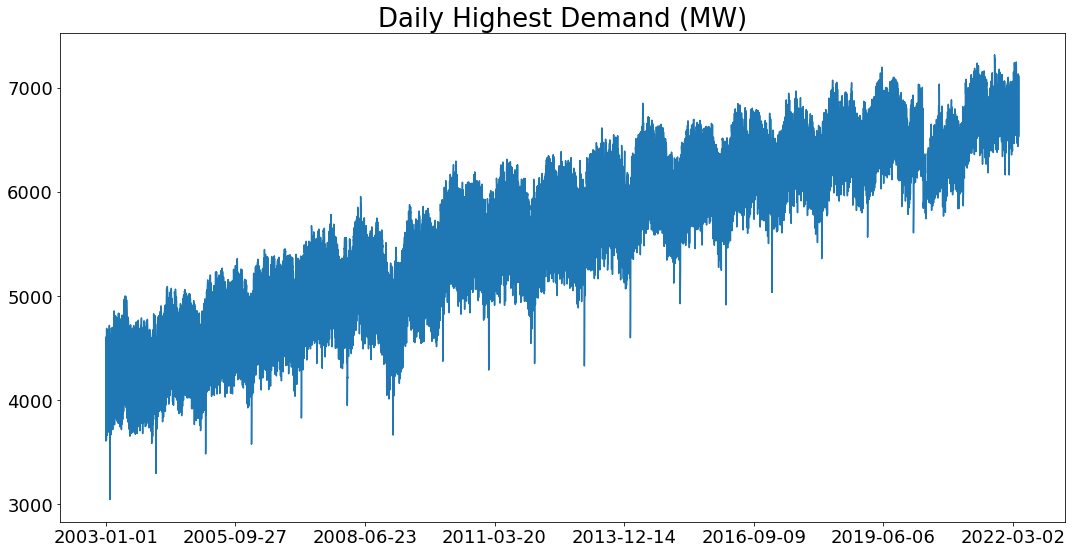

In [130]:
# Generate a time plot of our data.
plot_series(df, cols=['demand_mw'], title='Daily Highest Demand (MW)', steps=1000)

In [42]:
# Run ADF test on original (non-differenced!) data
interpret_dftest(adfuller(df['demand_mw']))

Test Statistic   -1.907824
p-value           0.328389
dtype: float64

Based on aggregated daily highest demand, the Augmented Dickey-Fuller test cannot reject the H0: not stationary (𝑝=0.33) and accept that our time series is stationary at significance level of 𝛼=0.01.

Next, we need to perform differencing to obtain a stationary time series before we can perform modelling.

In [44]:
# Create first_diff_demand and second_diff_demand
df['first_diff_demand'] = df['demand_mw'].diff()
df['second_diff_demand'] = df['demand_mw'].diff().diff()

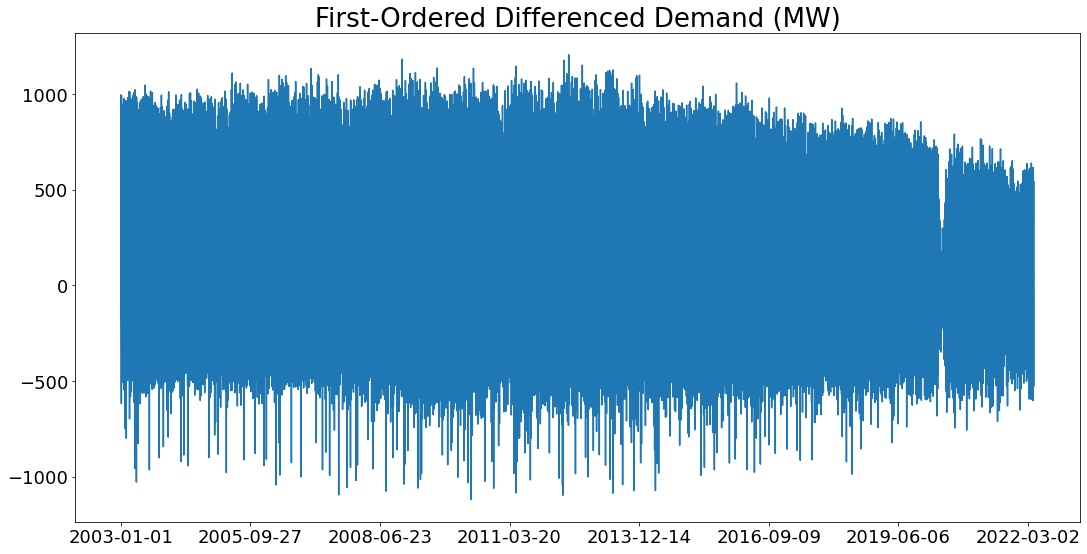

In [45]:
# Time plot of demand, differenced once
plot_series(df, cols=['first_diff_demand'], title='First-Ordered Differenced Demand (MW)', steps=1000)

In [46]:
# Run the ADF test on our once-differenced data.
interpret_dftest(adfuller(df['first_diff_demand'].dropna()))

Test Statistic   -20.714184
p-value            0.000000
dtype: float64

Based on Augmented Dickey-Fuller test of first-order differenced demand, we reject the H0: not stationary (𝑝=0.00) at significance level 𝛼=0.01 (i.e. stationary assumption is fulfilled). We can perform modelling using the first-order differenced daily highest demand.

We also explore exogenous predictors which we can use to predict peak electrity demand

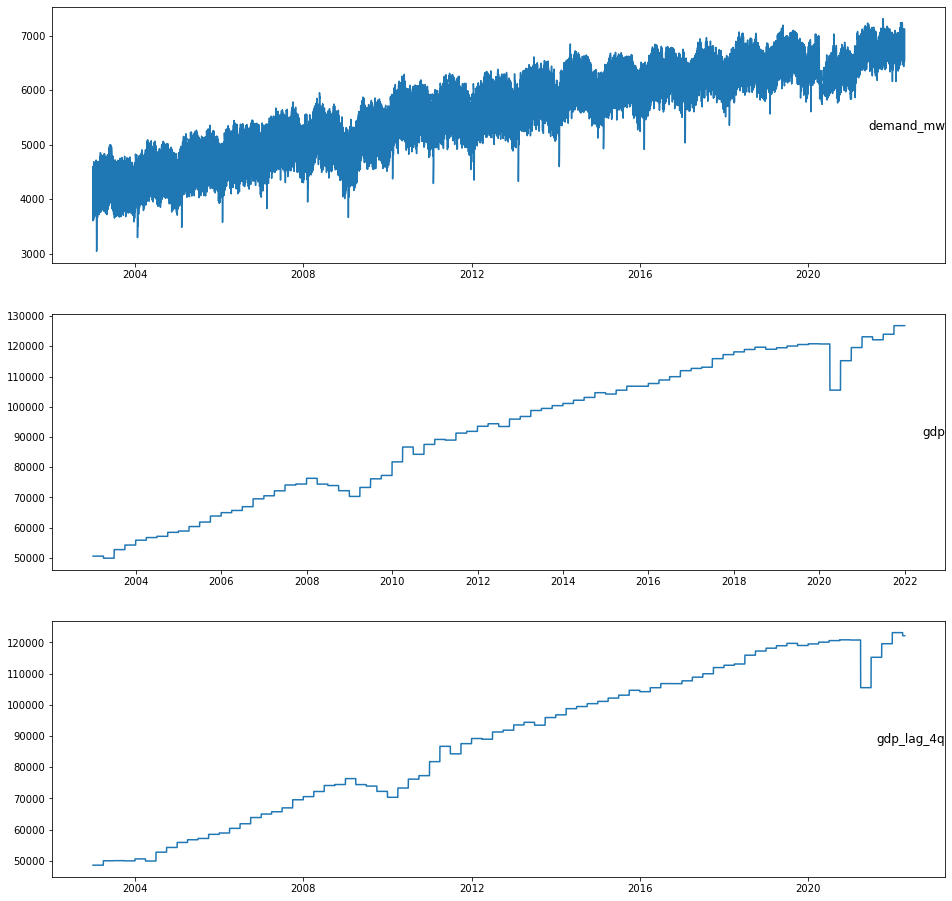

In [47]:
i = 1
plt.figure(figsize=(16,16))
for col in ['demand_mw', 'gdp', 'gdp_lag_4q']:
    plt.subplot(3, 1, i)
    plt.plot(df.loc[:, col])
    plt.title(col, y=0.5, loc='right')
    i += 1

The most evident exogenous predictor is GDP
- Based on the trend of daily highest demand, we observe that the demand generally increase over time but there were 2 instances of dip in the electricity demand in 2008 and 2020. These are due to:
    - Financial Crisis: Singapore falls into a recession from the global economic crisis in July 2008, which was Singapore's worst ever recession.
    - COVID-19: Singapore entered the Circuit Breaker (CB) period, to reduce the transmission of COVID-19 infections from 7 Apr 2020.
- Demand and GDP also trend very closely because ~85% of the total demand is attributed by the commercial and industrial sector so high GDP means more economic activities and higher electricity demand.
- To appropriately factor in GDP as exogenous predictor, we need to lag the quarterly GDP by a year (i.e. use 2021's GDP to predict demand in 2022 as we do not have sight of the 2022's GDP (we do not know what will happen tomorrow today))

In [48]:
# create a function to create dataframe to hold dummies and demand for specified categorical features
def dummies_demand_df(colname):
    dummies_df = df[[colname]]
    dummies_df = pd.get_dummies(dummies_df)
    dummy_plus_demand = pd.concat(objs = [dummies_df, df[['demand_mw']]] , axis = 1)
    return dummy_plus_demand

# crate a function to plot heatmap of correlation
def heatmap_corr(df, colname):
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    corr_matrix = sns.heatmap(df.corr(), mask=mask, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
    corr_matrix.set_title(f'Correlation Matrix Heatmap for {colname} and Demand', fontdict={'fontsize':18}, pad=12);

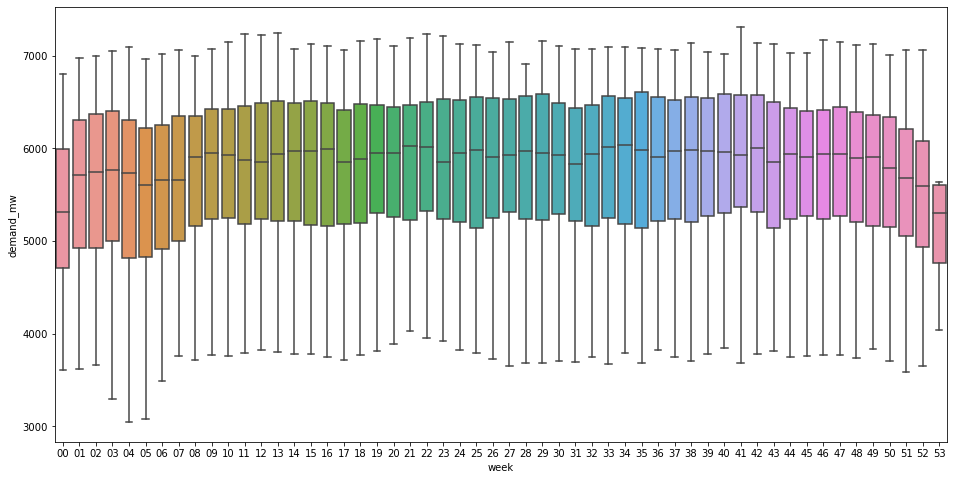

In [49]:
# create a column to indicate week
df['week'] = df.index.strftime('%U')
df['week'] = df['week'].astype(str)

plt.figure(figsize=(16,8))
sns.boxplot(x="week", y="demand_mw", data=df);

In addition to GDP, demand is usually higher in the middle of the year between Mar and Oct and lower at the start and end of the year due to holiday seasons

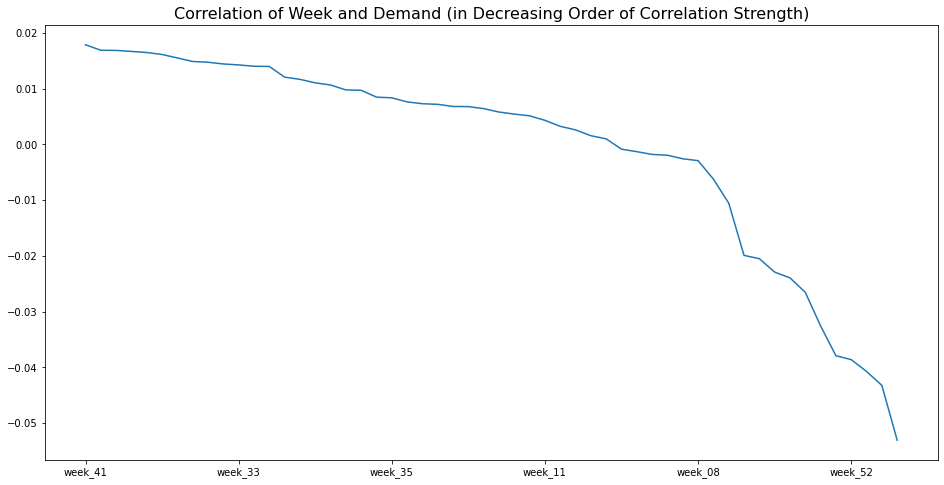

In [50]:
# Look at the correlation of week with demand
week_demand = dummies_demand_df('week')
corr = week_demand.corr().sort_values('demand_mw', ascending=False)

plt.figure(figsize=(16,8))
corr['demand_mw'].iloc[1:].plot()
plt.title(label = 'Correlation of Week and Demand (in Decreasing Order of Correlation Strength)', fontsize=16);

Based on the correlation of week and demand, the correlation is positive in the middle of the year and negative at the start and end of the year. We dummified weeks as it does not seem to have a linear linear relationship with demand.

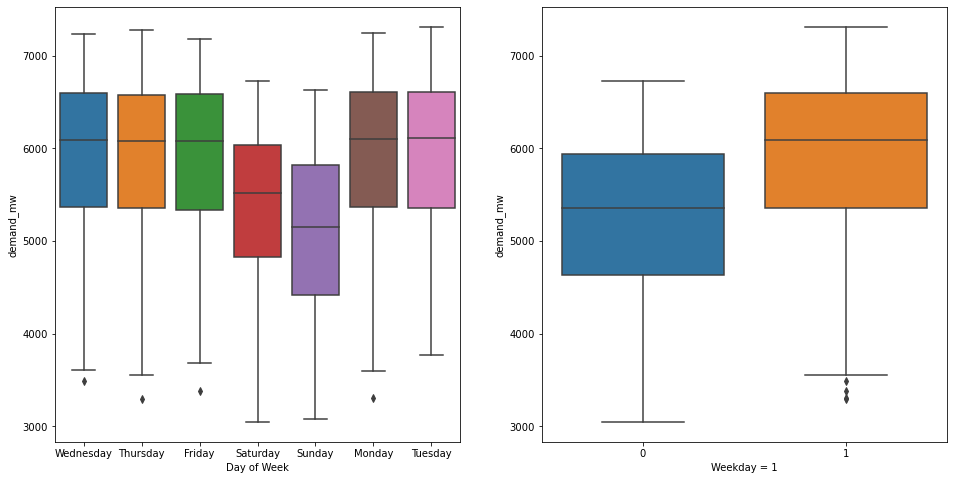

In [51]:
# distribution of demand by day of week
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
sns.boxplot(x="dayofweek", y="demand_mw", data=df).set_xlabel("Day of Week", fontsize = 10);

# create a column is_weekday when dayofweek is mon-fri
df['is_weekday'] = df['dayofweek'].map(lambda day: 1 if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 0)
df['is_weekday'] = df['is_weekday'].astype(int)

plt.subplot(1, 2, 2)
sns.boxplot(x="is_weekday", y="demand_mw", data=df).set_xlabel("Weekday = 1", fontsize = 10);

By day of week, demand is also higher on Mon to Fri than Sat and Sun. As demand on weekday is usually higher than weekends, regroup them into weekdays and weekends.

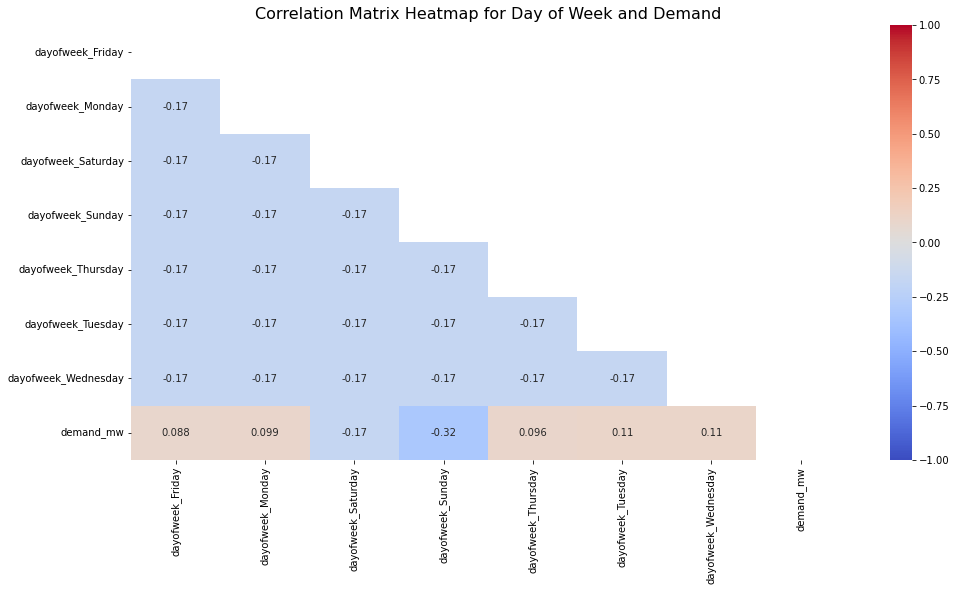

In [52]:
# Look at the correlation of dayofweek with demand
dayofweek_demand = dummies_demand_df('dayofweek')
corr = dayofweek_demand.corr().sort_values('demand_mw', ascending=False)

plt.figure(figsize=(16,8))
heatmap_corr(dayofweek_demand, 'demand_mw')
plt.title(label = 'Correlation Matrix Heatmap for Day of Week and Demand', fontsize=16);

 Based on correlation matrix heatmap of the day of week and demand, the relationship also does not seem linear so we dummified both day of week and weekdays/weekends and determine which is a better predictor through modelling.

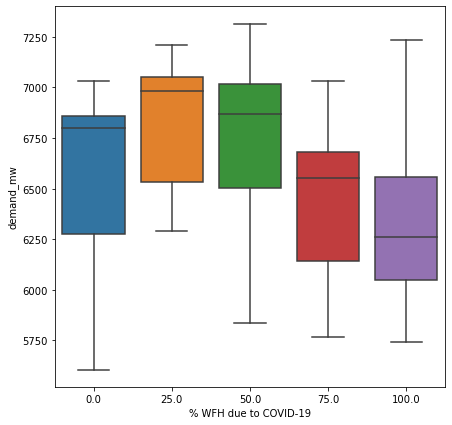

In [53]:
# distribution of demand by % WFH due to COVID-19
plt.figure(figsize=(7,7))
start_year_w_wfh_indicator = df.loc[df['wfh_indicator']>0,:].index.year.value_counts().index.min()
sns.boxplot(x="wfh_indicator", y="demand_mw", data=df.loc[df.index.year>=start_year_w_wfh_indicator,]).set_xlabel("% WFH due to COVID-19", fontsize = 10);

The last exogenous predictor explored was the % people WFH as a proxy of economy recovery. 
- Based on the boxplot, we see that demand was the lowest during Circuit Breaker period (100% WFH) when there was severe disruption to economic activities and almost everyone has to WFH, except for essential services. 
- Demand increases with easing of measures and more people returning to their workplaces.

In [54]:
# convert wfh_indicator from float to str
df['wfh_indicator'] = df['wfh_indicator'].astype(str)

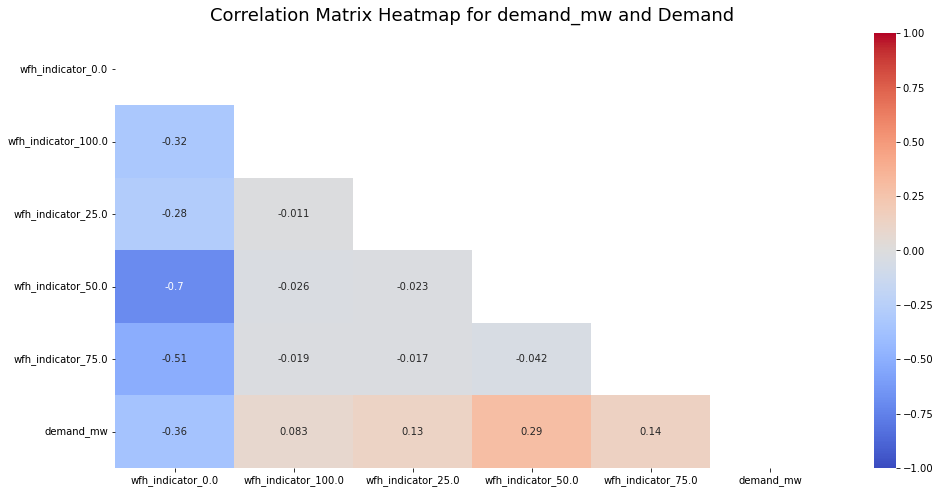

In [55]:
# Look at the correlation of wfh_indicator with demand
wfh_indicator_demand = dummies_demand_df('wfh_indicator')
corr = wfh_indicator_demand.corr().sort_values('demand_mw', ascending=False)

plt.figure(figsize=(16,8))
heatmap_corr(wfh_indicator_demand, 'demand_mw')

Similar to week and day of week, as the relationship between demand and % WFH does not seem linear, we dummified the % WFH

In [56]:
# Non-numeric features

non_numeric_features = [
    'week',
    'dayofweek',
    'is_ph',
    'wfh_indicator'
]

In [57]:
# Create a new dataframe to hold dummies for all categorical features
dummies_df = df[non_numeric_features]
dummies_df = pd.get_dummies(dummies_df, drop_first=True)
df.drop(columns=['week'], inplace = True)

# Add on the dummified week to df 
df = pd.concat(objs = [df, dummies_df], axis = 1)

In [131]:
df.head()

,period,demand_mw,covid_phase,wfh_indicator,dayofweek,is_ph,year,gdp,gdp_lag_4q,first_diff_demand,...,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,wfh_indicator_100.0,wfh_indicator_25.0,wfh_indicator_50.0,wfh_indicator_75.0
datetime,,,,,,,,,,,,,,,,,,,,,
2003-01-01,48,3610.635,Pre-CB,0.0,Wednesday,0,2003,50602.0,48589.8,NaN,...,0,0,0,0,0,1,0,0,0,0
2003-01-02,48,4605.873,Pre-CB,0.0,Thursday,0,2003,50602.0,48589.8,995.238,...,0,0,0,1,0,0,0,0,0,0
2003-01-03,48,4464.665,Pre-CB,0.0,Friday,0,2003,50602.0,48589.8,-141.208,...,0,0,0,0,0,0,0,0,0,0
2003-01-04,48,4233.381,Pre-CB,0.0,Saturday,0,2003,50602.0,48589.8,-231.284,...,0,1,0,0,0,0,0,0,0,0
2003-01-05,48,3615.402,Pre-CB,0.0,Sunday,0,2003,50602.0,48589.8,-617.979,...,0,0,1,0,0,0,0,0,0,0


# Model Exploration and Evaluation

- We first train-test split our data using 2003-2018 as train data and the last 3 years, 2019-2021, as test data
- Since the purpose of our study is to accurately predict peak demand for one-year ahead, we will forecast the demand for 1 year ahead based on all historical data (i.e. 2003-2018 to predict 2019, 2003-2019 to predict 2020, 2003-2020 to predict 2021)
- We then measure the error between actual and predicted peak for all 3 years and take a simple average of these errors as our evaluation metric

In [58]:
# create a function to train-test split data
def traintestsplit(df, starting_year_test):
    y_train = df.loc[df['year'] < starting_year_test, :]
    y_test = df.loc[df['year'] == starting_year_test, :]
    return y_train, y_test

In [59]:
# create 3 train-test-split datasets for 2019, 2020 and 2021 respectively
y_train_2021, y_test_2021 = traintestsplit(df, 2021)
y_train_2020, y_test_2020 = traintestsplit(df, 2020)
y_train_2019, y_test_2019 = traintestsplit(df, 2019)

## ARIMA

We first build our base model ARIMA with differenced 1 (d=1), while hypertuning for p and q to obtain the best ARIMA model

In [240]:
# create function to fit arima model on the 3 training datasets

def fit_arima(p, d, q):
    
    # Instantiate ARIMA model
    arima2021 = ARIMA(endog=y_train_2021['demand_mw'], order=(p, d, q))
    arima2020 = ARIMA(endog=y_train_2020['demand_mw'], order=(p, d, q))
    arima2019 = ARIMA(endog=y_train_2019['demand_mw'], order=(p, d, q))

    # Fit ARIMA model
    model2021 = arima2021.fit()
    model2020 = arima2020.fit()
    model2019 = arima2019.fit() 
    
    return model2019, model2020, model2021

In [241]:
# create function to provide one-year ahead predictions for the 3 training datasets

def predictions(model2019, model2020, model2021):
    
    # Generate predictions based on training set.
    preds2021 = model2021.predict(
        start=y_test_2021['demand_mw'].index[0], 
        end = y_test_2021['demand_mw'].index[-1]
        )
    preds2020 = model2020.predict(
        start=y_test_2020['demand_mw'].index[0], 
        end = y_test_2020['demand_mw'].index[-1]
        )
    preds2019 = model2019.predict(
        start=y_test_2019['demand_mw'].index[0], 
        end = y_test_2019['demand_mw'].index[-1]
        ) 
    
    return preds2019, preds2020, preds2021

In [242]:
# create functions to compute mse of peak demand for 3 one-year ahead predictions

def mse_peak_testing(preds2019, preds2020, preds2021):
    
    err2021 = abs(y_test_2021['demand_mw'].max() - preds2021.max())
    err2020 = abs(y_test_2020['demand_mw'].max() - preds2020.max())
    err2019 = abs(y_test_2019['demand_mw'].max() - preds2019.max())
    mse = (err2021 + err2020 + err2019) / 3
    
    return err2019, err2020, err2021, mse   

In [70]:
# grid search for optimal p and q for ARIMA model

# start with AIC, p, and q
final_mse = 99 * (10 ** 16)
final_p = 0
final_q = 0

# Use nested for loop to iterate over values of p and q
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements
        try:
            
            # Fitting an ARIMA(p, 1, q) model
            print(f'Attempting ARIMA({p}, 1, {q})')
 

            # Fit ARIMA model
            model2019, model2020, model2021 = fit_arima(p, 1, q)

            # Generate predictions based on training set
            preds2019, preds2020, preds2021 = predictions(model2019, model2020, model2021)

            # Evaluate predictions
            err2019, err2020, err2021, mse = mse_peak_testing(preds2019, preds2020, preds2021)
        
            print(f'The mean error for ({p}, 1, {q}) is: {mse}')

            # Save for final report
            if mse < final_mse:
                final_mse = mse
                final_p = p
                final_q = q
            
        except: # in general this is bad style but sometimes there is a NotFittedError
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes mean error on the testing data is the ARIMA({final_p},1,{final_q}).')
print(f'This model has a mean error of {final_mse} (2019: {err2019}; 2020: {err2020}; 2021: {err2021}).')

Attempting ARIMA(0, 1, 0)
The mean error for (0, 1, 0) is: 639.9336666666671
Attempting ARIMA(0, 1, 1)
The mean error for (0, 1, 1) is: 737.5853679762962
Attempting ARIMA(0, 1, 2)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The mean error for (0, 1, 2) is: 658.5126128047277
Attempting ARIMA(0, 1, 3)
The mean error for (0, 1, 3) is: 669.1055377878059
Attempting ARIMA(0, 1, 4)
The mean error for (0, 1, 4) is: 681.8997523397144
Attempting ARIMA(1, 1, 0)
The mean error for (1, 1, 0) is: 658.5051896995925
Attempting ARIMA(1, 1, 1)
The mean error for (1, 1, 1) is: 679.3182710093079
Attempting ARIMA(1, 1, 2)
The mean error for (1, 1, 2) is: 670.2802291404232
Attempting ARIMA(1, 1, 3)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 3) is: 665.2917515818857
Attempting ARIMA(1, 1, 4)
The mean error for (1, 1, 4) is: 686.0810005088248
Attempting ARIMA(2, 1, 0)
The mean error for (2, 1, 0) is: 662.6329781581895
Attempting ARIMA(2, 1, 1)
The mean error for (2, 1, 1) is: 649.9086495702701
Attempting ARIMA(2, 1, 2)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The mean error for (2, 1, 2) is: 668.2573811342536
Attempting ARIMA(2, 1, 3)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 3) is: 598.4585005145085
Attempting ARIMA(2, 1, 4)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 4) is: 472.1525757766758
Attempting ARIMA(3, 1, 0)
The mean error for (3, 1, 0) is: 649.162550364982
Attempting ARIMA(3, 1, 1)
The mean error for (3, 1, 1) is: 645.4996817396465
Attempting ARIMA(3, 1, 2)
The mean error for (3, 1, 2) is: 656.7410114709932
Attempting ARIMA(3, 1, 3)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (3, 1, 3) is: 444.2965843670751
Attempting ARIMA(3, 1, 4)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (3, 1, 4) is: 465.7074074475113
Attempting ARIMA(4, 1, 0)
The mean error for (4, 1, 0) is: 651.210398455188
Attempting ARIMA(4, 1, 1)
The mean error for (4, 1, 1) is: 679.5533081922991
Attempting ARIMA(4, 1, 2)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (4, 1, 2) is: 670.3023737773887
Attempting ARIMA(4, 1, 3)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (4, 1, 3) is: 479.4457899373356
Attempting ARIMA(4, 1, 4)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (4, 1, 4) is: 543.5068341667593


MODEL FINISHED!
Our model that minimizes mean error on the testing data is the ARIMA(3,1,3).
This model has a mean error of 444.2965843670751 (2019: 551.1908371567952; 2020: 348.1149303031325; 2021: 731.2147350403502).


In [71]:
# Fit ARIMA(3, 1, 3)
model2019, model2020, model2021 = fit_arima(3, 1, 3)

# Generate predictions based on training set
preds2019, preds2020, preds2021 = predictions(model2019, model2020, model2021)

# Evaluate predictions
err2019, err2020, err2021, mse = mse_peak_testing(preds2019, preds2020, preds2021)
print(f"Mean Error: {mse} (2019: {err2019}; 2020: {err2020}; 2021: {err2021})")
# MSE: 122966.48292221666
# RMSE: 350.66577095892416

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Mean Error: 444.2965843670751 (2019: 436.37765250025404; 2020: 226.06863724724008; 2021: 670.4434633537312)


In [72]:
# concat the predictions and actual test for 2019-2021
preds = pd.concat([preds2019, preds2020, preds2021])
y_test = pd.concat([y_test_2019, y_test_2020, y_test_2021])

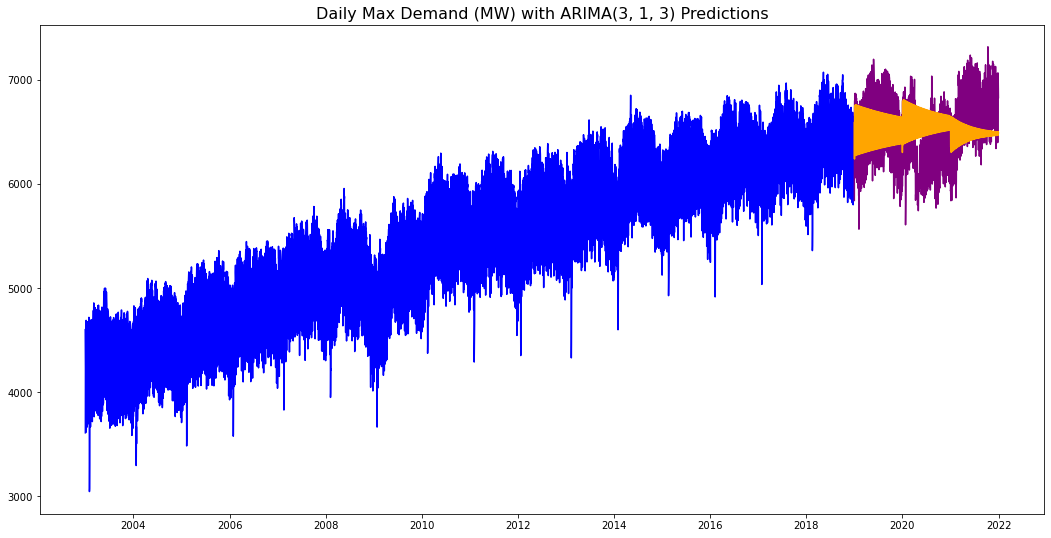

In [73]:
# Plot data for entire time horizon

plt.figure(figsize=(18,9))

# Plot training data
plt.plot(y_train_2019['demand_mw'].index, y_train_2019['demand_mw'], color = 'blue')

# Plot testing data
plt.plot(y_test['demand_mw'].index, y_test['demand_mw'], color = 'purple')

# Plot predicted test values
plt.plot(y_test['demand_mw'].index, preds, color = 'orange')

plt.title(label = 'Daily Max Demand (MW) with ARIMA(3, 1, 3) Predictions', fontsize=16)
plt.show();

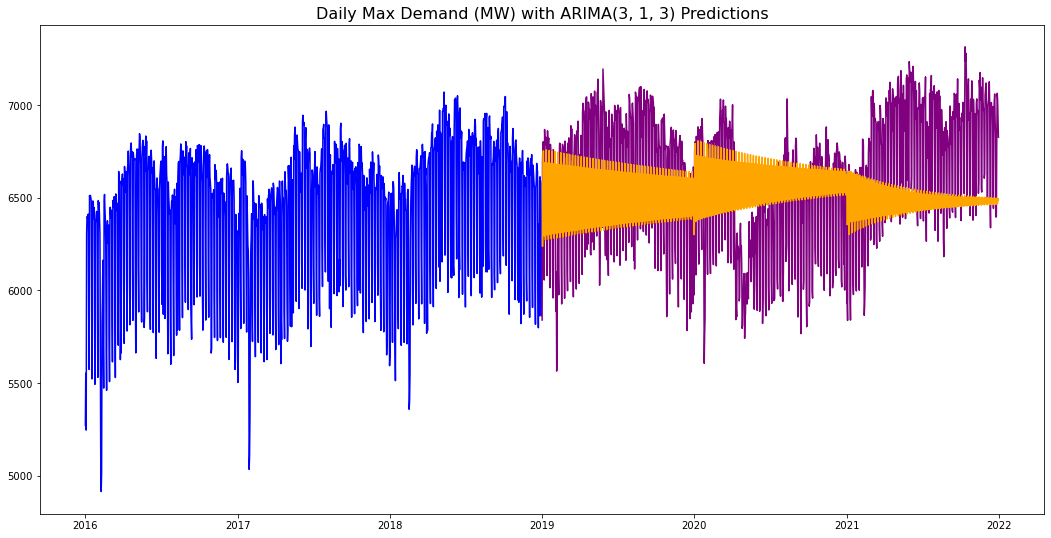

In [74]:
# Plot data for zoomed in time horizon from 2016

plt.figure(figsize=(18,9))

# Plot training data
plt.plot(y_train_2019['demand_mw'].index[4748:], y_train_2019['demand_mw'][4748:], color = 'blue')

# Plot testing data
plt.plot(y_test['demand_mw'].index, y_test['demand_mw'], color = 'purple')

# Plot predicted test values
plt.plot(y_test['demand_mw'].index, preds, color = 'orange')

plt.title(label = 'Daily Max Demand (MW) with ARIMA(3, 1, 3) Predictions', fontsize=16)
plt.show();

For ARIMA, model with the least errorl is (3,1,3) with an average error of 444MW. 
- To set this into context, a combined cycle power plant (CCGT) has capacity of about 600MW, so error of about 600MW will result in one more or one less power plant being built.

## Seasonal ARIMA (SARIMA)

Next we look at ACF and PACF plot of the first order differenced demand

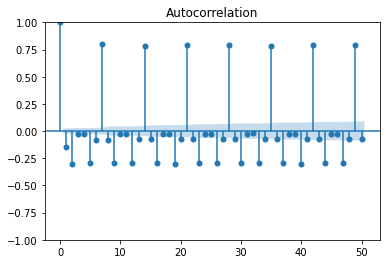

In [75]:
# Generate autocorrelation (ACF) plot on differenced data (to achieve stationarity)
# step 1: lag the values
# step 2: take the correlation
# step 3: ACF shows the raw correlation (e.g. at t-2, it is the correlation between t-2 and t)
#         PACF shows the direct correlation by removing the indirect corrlation 
#         (e.g. at t-2, the INDIRECT correlation through t-1 is removed, retaining only the DIRECT correlation with t), 
#         so PACF looks less pronounce
plot_acf(y_train_2019['first_diff_demand'].dropna(), lags = 50);

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


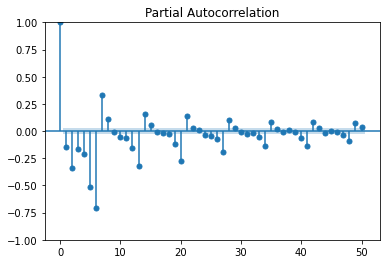

In [76]:
# Generate partial autocorrelation (PACF) plot on training data
plot_pacf(y_train_2019['first_diff_demand'].dropna(), lags = 50)

Based on ACF and PACF plot of the first order differenced demand, we can clearly see a seasonal pattern which suggests that SARIMA is likely to out-perform ARIMA

- Identifying the seasonal component of the model:
    - The cycle repeats every 7 days so we set S=7
    - The series has a strong and consistent seasonal pattern, so we use order of seasonal differencing (D) (otherwise the model assumes that the seasonal pattern will fade away over time). However, as we cannot use more than one order of seasonal differencing or more than 2 orders of total differencing (seasonal+nonseasonal), we set D=1
    - As the ACF on the first-ordered differenced demand is positive at lag 7, with 7 periods in each season, it is likely to have SAR terms (as opposed to SMA terms if it is negative)
- Identifying the numbers of AR and MA terms of non-seasonal component of the model:
    - Based on ACF, there is a sharp cut-off at between lags 0 and 1 and lag-1 autocorrelation is negative i.e. the series appears slightly "over-differenced", so it is likely to have MA terms (q = 0, 1, 2)
- As it is possible for an AR term and an MA term to cancel each other's effects, we will try a mixed AR-MA model, gridsearching for p and q for the non-seasonal component and P and Q for the non-seasonal component (p, q, P, Q = (0,1,2)), while fitting d=1, D=1 and S=7 (note: should try model with one fewer AR term and one fewer MA term instead of multiple AR and MA terms in the same model, as the parameter estimates in the original model may require more than 10 iterations to converge)
    

In [243]:
# create function to fit sarima model on the 3 training datasets

def fit_sarima(p, d, q, P, D, Q, S):

    # Instantiate SARIMA model
    sarima2021 = SARIMAX(endog = y_train_2021['demand_mw'],
                     order = (p, d, q),              # (p, d, q)
                     seasonal_order = (P, D, Q, S)) # (P, D, Q, S)
    sarima2020 = SARIMAX(endog = y_train_2020['demand_mw'],
                     order = (p, d, q),              # (p, d, q)
                     seasonal_order = (P, D, Q, S)) # (P, D, Q, S)
    sarima2019 = SARIMAX(endog = y_train_2019['demand_mw'],
                     order = (p, d, q),              # (p, d, q)
                     seasonal_order = (P, D, Q, S)) # (P, D, Q, S)

    # Fit SARIMA model
    model2021 = sarima2021.fit()
    model2020 = sarima2020.fit()
    model2019 = sarima2019.fit()
        
    return model2019, model2020, model2021

In [195]:
# grid search for optimal p and q for non-seasonal component and P, D, Q of seasonal component

# Starting MSE, (p, q) and (P, D, Q)
final_mse = 99 * (10 ** 16)
final_p = 0
final_q = 0
final_P = 0
final_D = 0
final_Q = 0

for p in range(3):
    for q in range(3):
        for P in range(3):
            for Q in range(3):
                for D in range(3):
                    try:

                        # Fitting an SARIMA(p, 1, q) model
                        print(f'Attempting SARIMA({p}, 1, {q})x({P},{D},{Q},7)')

                        # Fit SARIMA model
                        model2019, model2020, model2021 = fit_sarima(p, 1, q, P, D, Q, 7)

                        # Generate predictions based on training set
                        preds2019, preds2020, preds2021 = predictions(model2019, model2020, model2021)

                        # Evaluate predictions
                        err2019, err2020, err2021, mse = mse_peak_testing(preds2019, preds2020, preds2021)

                        print(f'The mean error for ({p}, 1, {q})x({P},{D},{Q},7) is: {mse}')

                        # Save for final report
                        if mse < final_mse:
                            final_mse = mse
                            final_p = p
                            final_q = q
                            final_P = P
                            final_D = D
                            final_Q = Q

                    except:
                        pass
                    
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes mean error on the training data is the SARIMA({final_p}, 1, {final_q})x({final_P},{final_D},{final_Q},7).')
print(f'This model has a mean error of {final_mse} (2019: {err2019}; 2020: {err2020}; 2021: {err2021}).')

Attempting SARIMA(0, 1, 0)x(0,0,0,7)
The MSE for (0, 1, 0)x(0,0,0,7) is: 639.9336666666671
Attempting SARIMA(0, 1, 0)x(0,1,0,7)
The MSE for (0, 1, 0)x(0,1,0,7) is: 5802.22133333333
Attempting SARIMA(0, 1, 0)x(0,2,0,7)
The MSE for (0, 1, 0)x(0,2,0,7) is: 348287.9173333312
Attempting SARIMA(0, 1, 0)x(0,0,1,7)
The MSE for (0, 1, 0)x(0,0,1,7) is: 519.1748897783294
Attempting SARIMA(0, 1, 0)x(0,1,1,7)
The MSE for (0, 1, 0)x(0,1,1,7) is: 632.653779629859
Attempting SARIMA(0, 1, 0)x(0,2,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(0,2,1,7) is: 4799.658622417653
Attempting SARIMA(0, 1, 0)x(0,0,2,7)
The MSE for (0, 1, 0)x(0,0,2,7) is: 445.04148302529
Attempting SARIMA(0, 1, 0)x(0,1,2,7)
The MSE for (0, 1, 0)x(0,1,2,7) is: 624.4785065919417
Attempting SARIMA(0, 1, 0)x(0,2,2,7)
The MSE for (0, 1, 0)x(0,2,2,7) is: 633.389091647848
Attempting SARIMA(0, 1, 0)x(1,0,0,7)
The MSE for (0, 1, 0)x(1,0,0,7) is: 334.5878734653261
Attempting SARIMA(0, 1, 0)x(1,1,0,7)
The MSE for (0, 1, 0)x(1,1,0,7) is: 2302.54092887086
Attempting SARIMA(0, 1, 0)x(1,2,0,7)
The MSE for (0, 1, 0)x(1,2,0,7) is: 175766.31883486523
Attempting SARIMA(0, 1, 0)x(1,0,1,7)
The MSE for (0, 1, 0)x(1,0,1,7) is: 632.6663035125124
Attempting SARIMA(0, 1, 0)x(1,1,1,7)
The MSE for (0, 1, 0)x(1,1,1,7) is: 625.3557126872407
Attempting SARIMA(0, 1, 0)x(1,2,1,7)
The MSE for (0, 1, 0)x(1,2,1,7) is: 1511.4454366932152
Attempting SARIMA(0, 1, 0)x(1,0,2,7)
The MSE for (0, 1, 0)x(1,0,2,7) is: 624.4849485922135
Attempting SARIMA(0, 1, 0)x(1,1,2,7)
T

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (0, 1, 0)x(2,0,2,7) is: 624.1532607578496
Attempting SARIMA(0, 1, 0)x(2,1,2,7)
The MSE for (0, 1, 0)x(2,1,2,7) is: 620.3946323264981
Attempting SARIMA(0, 1, 0)x(2,2,2,7)
The MSE for (0, 1, 0)x(2,2,2,7) is: 614.0290243236246
Attempting SARIMA(0, 1, 1)x(0,0,0,7)
The MSE for (0, 1, 1)x(0,0,0,7) is: 737.5853679762962
Attempting SARIMA(0, 1, 1)x(0,1,0,7)
The MSE for (0, 1, 1)x(0,1,0,7) is: 3070.3164506955286
Attempting SARIMA(0, 1, 1)x(0,2,0,7)
The MSE for (0, 1, 1)x(0,2,0,7) is: 168183.40883950147
Attempting SARIMA(0, 1, 1)x(0,0,1,7)
The MSE for (0, 1, 1)x(0,0,1,7) is: 640.500167903554
Attempting SARIMA(0, 1, 1)x(0,1,1,7)
The MSE for (0, 1, 1)x(0,1,1,7) is: 584.0538297537465
Attempting SARIMA(0, 1, 1)x(0,2,1,7)
The MSE for (0, 1, 1)x(0,2,1,7) is: 2503.3066709525638
Attempting SARIMA(0, 1, 1)x(0,0,2,7)
The MSE for (0, 1, 1)x(0,0,2,7) is: 607.214443821384
Attempting SARIMA(0, 1, 1)x(0,1,2,7)
The MSE for (0, 1, 1)x(0,1,2,7) is: 462.4422586236951
Attempting SARIMA(0, 1, 1)x(0,2,2,7

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (0, 1, 1)x(2,2,2,7) is: 740219395220.334
Attempting SARIMA(0, 1, 2)x(0,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The MSE for (0, 1, 2)x(0,0,0,7) is: 658.5126128047277
Attempting SARIMA(0, 1, 2)x(0,1,0,7)
The MSE for (0, 1, 2)x(0,1,0,7) is: 386.3502603662364
Attempting SARIMA(0, 1, 2)x(0,2,0,7)
The MSE for (0, 1, 2)x(0,2,0,7) is: 6318.416303634162
Attempting SARIMA(0, 1, 2)x(0,0,1,7)
The MSE for (0, 1, 2)x(0,0,1,7) is: 617.2066367998838
Attempting SARIMA(0, 1, 2)x(0,1,1,7)
The MSE for (0, 1, 2)x(0,1,1,7) is: 437.6787596321944
Attempting SARIMA(0, 1, 2)x(0,2,1,7)
The MSE for (0, 1, 2)x(0,2,1,7) is: 506.3745777615043
Attempting SARIMA(0, 1, 2)x(0,0,2,7)
The MSE for (0, 1, 2)x(0,0,2,7) is: 588.0091662747345
Attempting SARIMA(0, 1, 2)x(0,1,2,7)
The MSE for (0, 1, 2)x(0,1,2,7) is: 437.981198616653
Attempting SARIMA(0, 1, 2)x(0,2,2,7)
The MSE for (0, 1, 2)x(0,2,2,7) is: 546.0862481778349
Attempting SARIMA(0, 1, 2)x(1,0,0,7)
The MSE for (0, 1, 2)x(1,0,0,7) is: 570.8119212771302
Attempting SARIMA(0, 1, 2)x(1,1,0,7)
The MSE for (0, 1, 2)x(1,1,0,7) is: 356.3800395160306
Attempting SARIMA(0, 1, 2)x(1,2,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (0, 1, 2)x(1,2,2,7) is: 473.4535627152539
Attempting SARIMA(0, 1, 2)x(2,0,0,7)
The MSE for (0, 1, 2)x(2,0,0,7) is: 543.5932815653068
Attempting SARIMA(0, 1, 2)x(2,1,0,7)
The MSE for (0, 1, 2)x(2,1,0,7) is: 590.3291971151706
Attempting SARIMA(0, 1, 2)x(2,2,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (0, 1, 2)x(2,2,0,7) is: 21798.409265695595
Attempting SARIMA(0, 1, 2)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (0, 1, 2)x(2,0,1,7) is: 466.67822288333235
Attempting SARIMA(0, 1, 2)x(2,1,1,7)
The MSE for (0, 1, 2)x(2,1,1,7) is: 438.42543283008064
Attempting SARIMA(0, 1, 2)x(2,2,1,7)
The MSE for (0, 1, 2)x(2,2,1,7) is: 590.5294711629334
Attempting SARIMA(0, 1, 2)x(2,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (0, 1, 2)x(2,0,2,7) is: 13433125.78948692
Attempting SARIMA(0, 1, 2)x(2,1,2,7)
The MSE for (0, 1, 2)x(2,1,2,7) is: 582.8773267759246
Attempting SARIMA(0, 1, 2)x(2,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (0, 1, 2)x(2,2,2,7) is: 561.3768679797859
Attempting SARIMA(1, 1, 0)x(0,0,0,7)
The MSE for (1, 1, 0)x(0,0,0,7) is: 658.5051896995925
Attempting SARIMA(1, 1, 0)x(0,1,0,7)
The MSE for (1, 1, 0)x(0,1,0,7) is: 4711.275790385948
Attempting SARIMA(1, 1, 0)x(0,2,0,7)
The MSE for (1, 1, 0)x(0,2,0,7) is: 248868.63395444947
Attempting SARIMA(1, 1, 0)x(0,0,1,7)
The MSE for (1, 1, 0)x(0,0,1,7) is: 546.4994422210362
Attempting SARIMA(1, 1, 0)x(0,1,1,7)
The MSE for (1, 1, 0)x(0,1,1,7) is: 605.1894813430981
Attempting SARIMA(1, 1, 0)x(0,2,1,7)
The MSE for (1, 1, 0)x(0,2,1,7) is: 3890.9350606291373
Attempting SARIMA(1, 1, 0)x(0,0,2,7)
The MSE for (1, 1, 0)x(0,0,2,7) is: 484.6591107791055
Attempting SARIMA(1, 1, 0)x(0,1,2,7)
The MSE for (1, 1, 0)x(0,1,2,7) is: 600.4633770030459
Attempting SARIMA(1, 1, 0)x(0,2,2,7)
The MSE for (1, 1, 0)x(0,2,2,7) is: 596.1001554223458
Attempting SARIMA(1, 1, 0)x(1,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 0)x(1,0,0,7) is: 3077.5366943422086
Attempting SARIMA(1, 1, 0)x(1,1,0,7)
The MSE for (1, 1, 0)x(1,1,0,7) is: 2138.8782043870474
Attempting SARIMA(1, 1, 0)x(1,2,0,7)
The MSE for (1, 1, 0)x(1,2,0,7) is: 147916.6151517039
Attempting SARIMA(1, 1, 0)x(1,0,1,7)
The MSE for (1, 1, 0)x(1,0,1,7) is: 604.1147460226293
Attempting SARIMA(1, 1, 0)x(1,1,1,7)
The MSE for (1, 1, 0)x(1,1,1,7) is: 461.5646413683683
Attempting SARIMA(1, 1, 0)x(1,2,1,7)
The MSE for (1, 1, 0)x(1,2,1,7) is: 1555.1983889594692
Attempting SARIMA(1, 1, 0)x(1,0,2,7)
The MSE for (1, 1, 0)x(1,0,2,7) is: 467.9798849275791
Attempting SARIMA(1, 1, 0)x(1,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 0)x(1,1,2,7) is: 603.394379418778
Attempting SARIMA(1, 1, 0)x(1,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 0)x(1,2,2,7) is: 594.1803054066813
Attempting SARIMA(1, 1, 0)x(2,0,0,7)
Attempting SARIMA(1, 1, 0)x(2,1,0,7)
The MSE for (1, 1, 0)x(2,1,0,7) is: 599.6354333096793
Attempting SARIMA(1, 1, 0)x(2,2,0,7)
The MSE for (1, 1, 0)x(2,2,0,7) is: 76944.07231441424
Attempting SARIMA(1, 1, 0)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 0)x(2,0,1,7) is: 597.0346333448779
Attempting SARIMA(1, 1, 0)x(2,1,1,7)
The MSE for (1, 1, 0)x(2,1,1,7) is: 416.67838124987276
Attempting SARIMA(1, 1, 0)x(2,2,1,7)
The MSE for (1, 1, 0)x(2,2,1,7) is: 351.798215041658
Attempting SARIMA(1, 1, 0)x(2,0,2,7)
Attempting SARIMA(1, 1, 0)x(2,1,2,7)
The MSE for (1, 1, 0)x(2,1,2,7) is: 594.5457872251833
Attempting SARIMA(1, 1, 0)x(2,2,2,7)
The MSE for (1, 1, 0)x(2,2,2,7) is: 585.6762853040449
Attempting SARIMA(1, 1, 1)x(0,0,0,7)
The MSE for (1, 1, 1)x(0,0,0,7) is: 679.3182710093079
Attempting SARIMA(1, 1, 1)x(0,1,0,7)
The MSE for (1, 1, 1)x(0,1,0,7) is: 387.4575080119442
Attempting SARIMA(1, 1, 1)x(0,2,0,7)
The MSE for (1, 1, 1)x(0,2,0,7) is: 6610.059485326536
Attempting SARIMA(1, 1, 1)x(0,0,1,7)
The MSE for (1, 1, 1)x(0,0,1,7) is: 603.0162124408589
Attempting SARIMA(1, 1, 1)x(0,1,1,7)
The MSE for (1, 1, 1)x(0,1,1,7) is: 470.29882087726793
Attempting SARIMA(1, 1, 1)x(0,2,1,7)
The MSE for (1, 1, 1)x(0,2,1,7) is: 495.223040649748

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 1)x(0,2,2,7) is: 456.3835106846021
Attempting SARIMA(1, 1, 1)x(1,0,0,7)
The MSE for (1, 1, 1)x(1,0,0,7) is: 610.1063044892313
Attempting SARIMA(1, 1, 1)x(1,1,0,7)
The MSE for (1, 1, 1)x(1,1,0,7) is: 383.52602528969663
Attempting SARIMA(1, 1, 1)x(1,2,0,7)
The MSE for (1, 1, 1)x(1,2,0,7) is: 2024.3391417062805
Attempting SARIMA(1, 1, 1)x(1,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 1)x(1,0,1,7) is: 495.9981780997411
Attempting SARIMA(1, 1, 1)x(1,1,1,7)
The MSE for (1, 1, 1)x(1,1,1,7) is: 394.98227597828037
Attempting SARIMA(1, 1, 1)x(1,2,1,7)
The MSE for (1, 1, 1)x(1,2,1,7) is: 498.9385839221359
Attempting SARIMA(1, 1, 1)x(1,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 1)x(1,0,2,7) is: 6606279.425735501
Attempting SARIMA(1, 1, 1)x(1,1,2,7)
The MSE for (1, 1, 1)x(1,1,2,7) is: 473.00296656408074
Attempting SARIMA(1, 1, 1)x(1,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 1)x(1,2,2,7) is: 390.49091880484656
Attempting SARIMA(1, 1, 1)x(2,0,0,7)
The MSE for (1, 1, 1)x(2,0,0,7) is: 571.7775750787187
Attempting SARIMA(1, 1, 1)x(2,1,0,7)
The MSE for (1, 1, 1)x(2,1,0,7) is: 398.4118236534111
Attempting SARIMA(1, 1, 1)x(2,2,0,7)
The MSE for (1, 1, 1)x(2,2,0,7) is: 486.1988715437671
Attempting SARIMA(1, 1, 1)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 1)x(2,0,1,7) is: 348.65559481681674
Attempting SARIMA(1, 1, 1)x(2,1,1,7)
The MSE for (1, 1, 1)x(2,1,1,7) is: 411.00237669201516
Attempting SARIMA(1, 1, 1)x(2,2,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 1)x(2,2,1,7) is: 84579256546.38666
Attempting SARIMA(1, 1, 1)x(2,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 1)x(2,0,2,7) is: 2358421.278657975
Attempting SARIMA(1, 1, 1)x(2,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 1)x(2,1,2,7) is: 572.4629815095547
Attempting SARIMA(1, 1, 1)x(2,2,2,7)
The MSE for (1, 1, 1)x(2,2,2,7) is: 498.4777713603219
Attempting SARIMA(1, 1, 2)x(0,0,0,7)
The MSE for (1, 1, 2)x(0,0,0,7) is: 670.2802291404232
Attempting SARIMA(1, 1, 2)x(0,1,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The MSE for (1, 1, 2)x(0,1,0,7) is: 418.0465824550741
Attempting SARIMA(1, 1, 2)x(0,2,0,7)
The MSE for (1, 1, 2)x(0,2,0,7) is: 6603.096191095089
Attempting SARIMA(1, 1, 2)x(0,0,1,7)
The MSE for (1, 1, 2)x(0,0,1,7) is: 613.9749742601052
Attempting SARIMA(1, 1, 2)x(0,1,1,7)
The MSE for (1, 1, 2)x(0,1,1,7) is: 302.92198938675637
Attempting SARIMA(1, 1, 2)x(0,2,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 2)x(0,2,1,7) is: 492.9897820706695
Attempting SARIMA(1, 1, 2)x(0,0,2,7)
The MSE for (1, 1, 2)x(0,0,2,7) is: 577.4426020270843
Attempting SARIMA(1, 1, 2)x(0,1,2,7)
The MSE for (1, 1, 2)x(0,1,2,7) is: 290.7920919085612
Attempting SARIMA(1, 1, 2)x(0,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 2)x(0,2,2,7) is: 146314602.34057638
Attempting SARIMA(1, 1, 2)x(1,0,0,7)
The MSE for (1, 1, 2)x(1,0,0,7) is: 605.8935943195611
Attempting SARIMA(1, 1, 2)x(1,1,0,7)
The MSE for (1, 1, 2)x(1,1,0,7) is: 421.6127383487598
Attempting SARIMA(1, 1, 2)x(1,2,0,7)
The MSE for (1, 1, 2)x(1,2,0,7) is: 2153.7629963931977
Attempting SARIMA(1, 1, 2)x(1,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 2)x(1,0,1,7) is: 4240255.238181488
Attempting SARIMA(1, 1, 2)x(1,1,1,7)
The MSE for (1, 1, 2)x(1,1,1,7) is: 295.35685388242655
Attempting SARIMA(1, 1, 2)x(1,2,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 2)x(1,2,1,7) is: 288535017279.68005
Attempting SARIMA(1, 1, 2)x(1,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 2)x(1,0,2,7) is: 228.13639130001593
Attempting SARIMA(1, 1, 2)x(1,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 2)x(1,1,2,7) is: 387.0361777664718
Attempting SARIMA(1, 1, 2)x(1,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 2)x(1,2,2,7) is: 2634.9719059373065
Attempting SARIMA(1, 1, 2)x(2,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 2)x(2,0,0,7) is: 17160.85476947371
Attempting SARIMA(1, 1, 2)x(2,1,0,7)
The MSE for (1, 1, 2)x(2,1,0,7) is: 479.77106252499317
Attempting SARIMA(1, 1, 2)x(2,2,0,7)
The MSE for (1, 1, 2)x(2,2,0,7) is: 728.8486263950963
Attempting SARIMA(1, 1, 2)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 2)x(2,0,1,7) is: 8717985.860791942
Attempting SARIMA(1, 1, 2)x(2,1,1,7)
The MSE for (1, 1, 2)x(2,1,1,7) is: 316.5434071275795
Attempting SARIMA(1, 1, 2)x(2,2,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Attempting SARIMA(1, 1, 2)x(2,0,2,7)
Attempting SARIMA(1, 1, 2)x(2,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 2)x(2,1,2,7) is: 401.4481516965513
Attempting SARIMA(1, 1, 2)x(2,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (1, 1, 2)x(2,2,2,7) is: 1542437048523.0706
Attempting SARIMA(2, 1, 0)x(0,0,0,7)
The MSE for (2, 1, 0)x(0,0,0,7) is: 662.6329781581895
Attempting SARIMA(2, 1, 0)x(0,1,0,7)
The MSE for (2, 1, 0)x(0,1,0,7) is: 4215.086417223566
Attempting SARIMA(2, 1, 0)x(0,2,0,7)
The MSE for (2, 1, 0)x(0,2,0,7) is: 212761.03473084792
Attempting SARIMA(2, 1, 0)x(0,0,1,7)
The MSE for (2, 1, 0)x(0,0,1,7) is: 593.0843216142493
Attempting SARIMA(2, 1, 0)x(0,1,1,7)
The MSE for (2, 1, 0)x(0,1,1,7) is: 513.833289125715
Attempting SARIMA(2, 1, 0)x(0,2,1,7)
The MSE for (2, 1, 0)x(0,2,1,7) is: 3521.604604482396
Attempting SARIMA(2, 1, 0)x(0,0,2,7)
The MSE for (2, 1, 0)x(0,0,2,7) is: 535.1810222078948
Attempting SARIMA(2, 1, 0)x(0,1,2,7)
The MSE for (2, 1, 0)x(0,1,2,7) is: 402.53384121010305
Attempting SARIMA(2, 1, 0)x(0,2,2,7)
The MSE for (2, 1, 0)x(0,2,2,7) is: 579.2587979360109
Attempting SARIMA(2, 1, 0)x(1,0,0,7)
The MSE for (2, 1, 0)x(1,0,0,7) is: 303.54046053093344
Attempting SARIMA(2, 1, 0)x(1,1,0

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 0)x(2,0,2,7) is: 613155.8329338713
Attempting SARIMA(2, 1, 0)x(2,1,2,7)
The MSE for (2, 1, 0)x(2,1,2,7) is: 498.78798914525004
Attempting SARIMA(2, 1, 0)x(2,2,2,7)
The MSE for (2, 1, 0)x(2,2,2,7) is: 551.0966693666269
Attempting SARIMA(2, 1, 1)x(0,0,0,7)
The MSE for (2, 1, 1)x(0,0,0,7) is: 649.9086495702701
Attempting SARIMA(2, 1, 1)x(0,1,0,7)
The MSE for (2, 1, 1)x(0,1,0,7) is: 364.5744470879733
Attempting SARIMA(2, 1, 1)x(0,2,0,7)
The MSE for (2, 1, 1)x(0,2,0,7) is: 6603.681691337788
Attempting SARIMA(2, 1, 1)x(0,0,1,7)
The MSE for (2, 1, 1)x(0,0,1,7) is: 621.3092896928347
Attempting SARIMA(2, 1, 1)x(0,1,1,7)
The MSE for (2, 1, 1)x(0,1,1,7) is: 429.300095589592
Attempting SARIMA(2, 1, 1)x(0,2,1,7)
The MSE for (2, 1, 1)x(0,2,1,7) is: 460.3074236590334
Attempting SARIMA(2, 1, 1)x(0,0,2,7)
The MSE for (2, 1, 1)x(0,0,2,7) is: 577.0280255818749
Attempting SARIMA(2, 1, 1)x(0,1,2,7)
The MSE for (2, 1, 1)x(0,1,2,7) is: 193.5017934730331
Attempting SARIMA(2, 1, 1)x(0,2,2,7)

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 1)x(0,2,2,7) is: 301.10228167952147
Attempting SARIMA(2, 1, 1)x(1,0,0,7)
The MSE for (2, 1, 1)x(1,0,0,7) is: 604.1610420676865
Attempting SARIMA(2, 1, 1)x(1,1,0,7)
The MSE for (2, 1, 1)x(1,1,0,7) is: 380.26325810103907
Attempting SARIMA(2, 1, 1)x(1,2,0,7)
The MSE for (2, 1, 1)x(1,2,0,7) is: 2097.325220005689
Attempting SARIMA(2, 1, 1)x(1,0,1,7)
Attempting SARIMA(2, 1, 1)x(1,1,1,7)
The MSE for (2, 1, 1)x(1,1,1,7) is: 275.8729187546084
Attempting SARIMA(2, 1, 1)x(1,2,1,7)
The MSE for (2, 1, 1)x(1,2,1,7) is: 498.0805872154736
Attempting SARIMA(2, 1, 1)x(1,0,2,7)
Attempting SARIMA(2, 1, 1)x(1,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 1)x(1,1,2,7) is: 551.5920178982806
Attempting SARIMA(2, 1, 1)x(1,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 1)x(1,2,2,7) is: 219563702824.65274
Attempting SARIMA(2, 1, 1)x(2,0,0,7)
The MSE for (2, 1, 1)x(2,0,0,7) is: 569.0973787356357
Attempting SARIMA(2, 1, 1)x(2,1,0,7)
The MSE for (2, 1, 1)x(2,1,0,7) is: 398.60857279058956
Attempting SARIMA(2, 1, 1)x(2,2,0,7)
The MSE for (2, 1, 1)x(2,2,0,7) is: 657.3506938106611
Attempting SARIMA(2, 1, 1)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 1)x(2,0,1,7) is: 2642.444969811848
Attempting SARIMA(2, 1, 1)x(2,1,1,7)
The MSE for (2, 1, 1)x(2,1,1,7) is: 189.67599546081055
Attempting SARIMA(2, 1, 1)x(2,2,1,7)
The MSE for (2, 1, 1)x(2,2,1,7) is: 510.6953844338159
Attempting SARIMA(2, 1, 1)x(2,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Attempting SARIMA(2, 1, 1)x(2,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 1)x(2,1,2,7) is: 551.1693603733214
Attempting SARIMA(2, 1, 1)x(2,2,2,7)
The MSE for (2, 1, 1)x(2,2,2,7) is: 498.37465665820946
Attempting SARIMA(2, 1, 2)x(0,0,0,7)
The MSE for (2, 1, 2)x(0,0,0,7) is: 668.2573811342536
Attempting SARIMA(2, 1, 2)x(0,1,0,7)
The MSE for (2, 1, 2)x(0,1,0,7) is: 370.9739837530345
Attempting SARIMA(2, 1, 2)x(0,2,0,7)
The MSE for (2, 1, 2)x(0,2,0,7) is: 6419.453463076255
Attempting SARIMA(2, 1, 2)x(0,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 2)x(0,0,1,7) is: 640.5555825912346
Attempting SARIMA(2, 1, 2)x(0,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 2)x(0,1,1,7) is: 389.1799962003076
Attempting SARIMA(2, 1, 2)x(0,2,1,7)
The MSE for (2, 1, 2)x(0,2,1,7) is: 495.3896096670278
Attempting SARIMA(2, 1, 2)x(0,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 2)x(0,0,2,7) is: 594.8558993142005
Attempting SARIMA(2, 1, 2)x(0,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 2)x(0,1,2,7) is: 404.00393661649315
Attempting SARIMA(2, 1, 2)x(0,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 2)x(0,2,2,7) is: 459.1976816597659
Attempting SARIMA(2, 1, 2)x(1,0,0,7)
The MSE for (2, 1, 2)x(1,0,0,7) is: 549.6216370034199
Attempting SARIMA(2, 1, 2)x(1,1,0,7)
The MSE for (2, 1, 2)x(1,1,0,7) is: 383.530686826896
Attempting SARIMA(2, 1, 2)x(1,2,0,7)
The MSE for (2, 1, 2)x(1,2,0,7) is: 2025.2783706545215
Attempting SARIMA(2, 1, 2)x(1,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Attempting SARIMA(2, 1, 2)x(1,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 2)x(1,1,1,7) is: 381.11128683987863
Attempting SARIMA(2, 1, 2)x(1,2,1,7)
The MSE for (2, 1, 2)x(1,2,1,7) is: 498.68635644002734
Attempting SARIMA(2, 1, 2)x(1,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Attempting SARIMA(2, 1, 2)x(1,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 2)x(1,1,2,7) is: 432.3803764359054
Attempting SARIMA(2, 1, 2)x(1,2,2,7)
The MSE for (2, 1, 2)x(1,2,2,7) is: 445.83136585358744
Attempting SARIMA(2, 1, 2)x(2,0,0,7)
The MSE for (2, 1, 2)x(2,0,0,7) is: 571.5354192881201
Attempting SARIMA(2, 1, 2)x(2,1,0,7)
The MSE for (2, 1, 2)x(2,1,0,7) is: 398.37178478696325
Attempting SARIMA(2, 1, 2)x(2,2,0,7)
The MSE for (2, 1, 2)x(2,2,0,7) is: 486.47900522505915
Attempting SARIMA(2, 1, 2)x(2,0,1,7)
Attempting SARIMA(2, 1, 2)x(2,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 2)x(2,1,1,7) is: 505.53217276716833
Attempting SARIMA(2, 1, 2)x(2,2,1,7)
The MSE for (2, 1, 2)x(2,2,1,7) is: 508.3591172275622
Attempting SARIMA(2, 1, 2)x(2,0,2,7)
Attempting SARIMA(2, 1, 2)x(2,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The MSE for (2, 1, 2)x(2,1,2,7) is: 422.2546323942103
Attempting SARIMA(2, 1, 2)x(2,2,2,7)


MODEL FINISHED!
Our model that minimizes MSE on the training data is the SARIMA(2, 1, 1)x(2,1,1,7).
This model has a mean error of 189.67599546081055 (2019: 425.33293002749633; 2020: 157.1844711474123; 2021: 684.2464960077223).


In [202]:
# Fit SARIMA(2, 1, 1) x (2, 1, 1, 7) model

model2019, model2020, model2021 = fit_sarima(2, 1, 1, 2, 1, 1, 7)

# Generate predictions based on training set
preds2019, preds2020, preds2021 = predictions(model2019, model2020, model2021)

# Evaluate predictions
err2019, err2020, err2021, mse = mse_peak_testing(preds2019, preds2020, preds2021)
print(f"MSE: {mse} (2019: {err2019}; 2020: {err2020}; 2021: {err2021})")
# MSE: 71911.48388434823
# RMSE: 268.1631665317745

MSE: 189.67599546081055 (2019: 179.58517494994703; 2020: 53.67530558656745; 2021: 335.7675058459172)


In [203]:
# concat the predictions and actual test for 2019-2021
preds = pd.concat([preds2019, preds2020, preds2021])
y_test = pd.concat([y_test_2019, y_test_2020, y_test_2021])

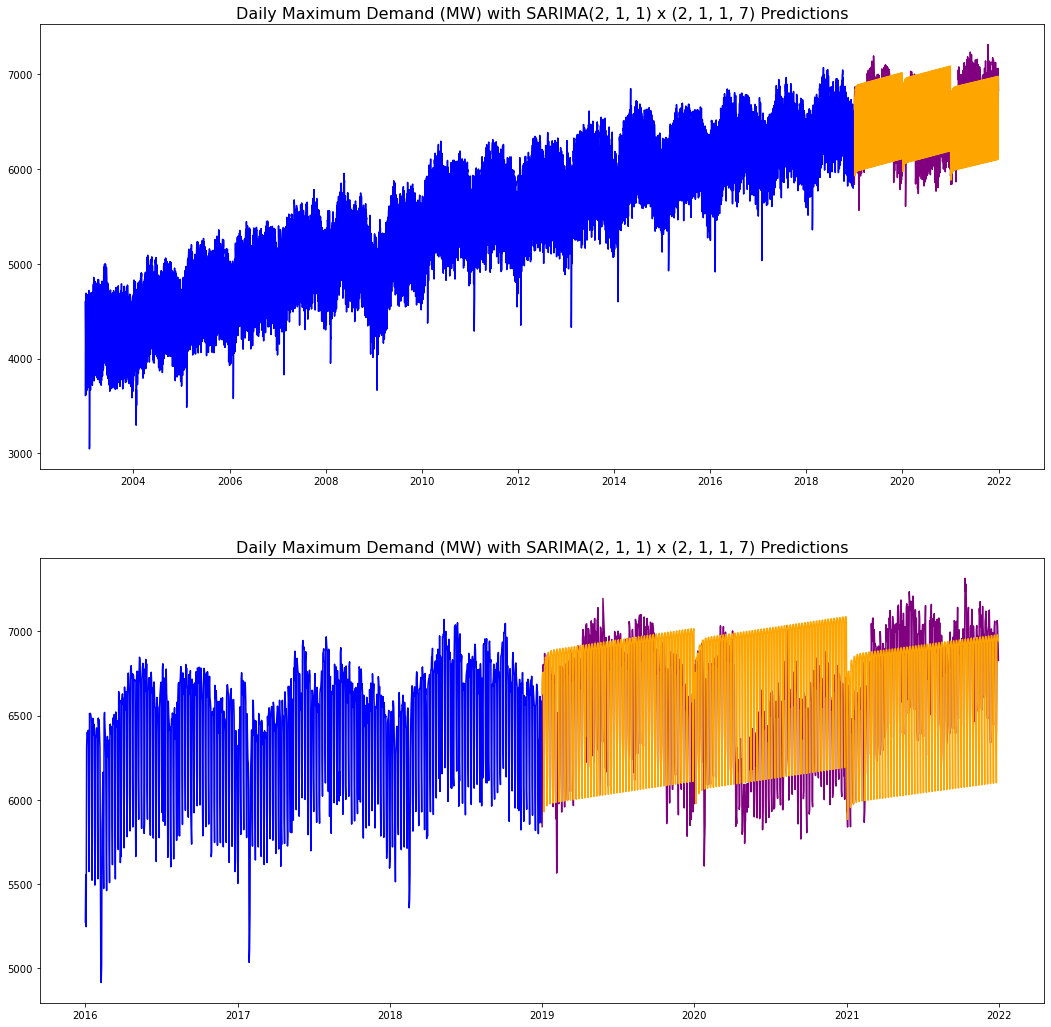

In [204]:
# Plot data for entire time horizon
plt.figure(figsize=(18, 18))

plt.subplot(2, 1, 1)
# Plot training data
plt.plot(y_train_2019['demand_mw'].index, y_train_2019['demand_mw'], color = 'blue')
# Plot testing data
plt.plot(y_test['demand_mw'].index, y_test['demand_mw'], color = 'purple')
# Plot predicted test values
plt.plot(y_test['demand_mw'].index, preds, color = 'orange')
plt.title(label = 'Daily Maximum Demand (MW) with SARIMA(2, 1, 1) x (2, 1, 1, 7) Predictions', fontsize=16)

# Plot data for zoomed in time horizon from 2016
# Plot training data
plt.subplot(2, 1, 2)
plt.plot(y_train_2019['demand_mw'].index[4748:], y_train_2019['demand_mw'][4748:], color = 'blue')
# Plot testing data
plt.plot(y_test['demand_mw'].index, y_test['demand_mw'], color = 'purple')
# Plot predicted test values
plt.plot(y_test['demand_mw'].index, preds, color = 'orange')
plt.title(label = 'Daily Maximum Demand (MW) with SARIMA(2, 1, 1) x (2, 1, 1, 7) Predictions', fontsize=16)
plt.show();


For SARIMA, model with the least error is (2, 1, 1)x(2,1,1,7) with a lower average error of 190 MW (ARIMA: 444 MW)

## SARIMAX (SARIMA with eXogenous predictors)

- To increase the performance of our model, we can also incorporate exogenous predictors to build a SARIMAX model
- We will explore individual and a combination of the 5 features (i.e. quarterly GDP of 1-year lag, week, day of week/is_weekday, % WFH due to COVID-19) which are identified in the EDA

In [244]:
# create function to fit sarimax model on the 3 training datasets

def fit_sarimax(p, d, q, P, D, Q, S, list_of_exog):

    # Instantiate SARIMA model
    sarimax2021 = SARIMAX(endog = y_train_2021['demand_mw'].iloc[1:],
                     order = (p, d, q),              # (p, d, q)
                     seasonal_order = (P, D, Q, S), # (P, D, Q, S)
                    exog = y_train_2021[list_of_exog].iloc[1:])
    sarimax2020 = SARIMAX(endog = y_train_2020['demand_mw'].iloc[1:],
                     order = (p, d, q),              # (p, d, q)
                     seasonal_order = (P, D, Q, S), # (P, D, Q, S)
                    exog = y_train_2020[list_of_exog].iloc[1:])
    sarimax2019 = SARIMAX(endog = y_train_2019['demand_mw'].iloc[1:],
                     order = (p, d, q),              # (p, d, q)
                     seasonal_order = (P, D, Q, S), # (P, D, Q, S)
                    exog = y_train_2019[list_of_exog].iloc[1:])

    # Fit SARIMA model
    model2021 = sarimax2021.fit()
    model2020 = sarimax2020.fit()
    model2019 = sarimax2019.fit()
        
    return model2019, model2020, model2021

In [245]:
# create function to provide one-year ahead predictions with exogenous predictors for the 3 training datasets

def predictions_w_exog(model2019, model2020, model2021, list_of_exog):
    
    # Generate predictions based on training set.
    preds2021 = model2021.predict(
        start=y_test_2021['demand_mw'].index[0], 
        end = y_test_2021['demand_mw'].index[-1], 
        exog=y_test_2021[list_of_exog],
        )
    preds2020 = model2020.predict(
        start=y_test_2020['demand_mw'].index[0], 
        end = y_test_2020['demand_mw'].index[-1],
        exog=y_test_2020[list_of_exog],
        )
    preds2019 = model2019.predict(
        start=y_test_2019['demand_mw'].index[0], 
        end = y_test_2019['demand_mw'].index[-1],
        exog=y_test_2019[list_of_exog],
        ) 
    
    return preds2019, preds2020, preds2021

In [253]:
# create function to return mean error and visualise predictions for selected exogeneous predictors

def fit_pred_visualise_sarimax(p, d, q, P, D, Q, S, list_of_exog):
    
    # Fit SARIMAX(1, 1, 2) x (2, 1, 1, 7) with exogeneous predictors
    model2019, model2020, model2021 = fit_sarimax(p, d, q, P, D, Q, S, list_of_exog)

    # Generate predictions based on training set
    preds2019, preds2020, preds2021 = predictions_w_exog(model2019, model2020, model2021, list_of_exog)

    # Evaluate predictions
    err2019, err2020, err2021, mse = mse_peak_testing(preds2019, preds2020, preds2021)
    print(f"MSE: {mse} (2019: {err2019}; 2020: {err2020}; 2021: {err2021})")
    
    # concat the predictions and actual test for 2019-2021
    preds = pd.concat([preds2019, preds2020, preds2021])
    y_test = pd.concat([y_test_2019, y_test_2020, y_test_2021])
     
    # Plot data for entire time horizon
    plt.figure(figsize=(18, 18))

    plt.subplot(2, 1, 1)
    # Plot training data
    plt.plot(y_train_2019['demand_mw'].index, y_train_2019['demand_mw'], color = 'blue')
    # Plot testing data
    plt.plot(y_test['demand_mw'].index, y_test['demand_mw'], color = 'purple')
    # Plot predicted test values
    plt.plot(y_test['demand_mw'].index, preds, color = 'orange')
    plt.title(label = f"Daily Maximum Demand (MW) with SARIMA({p}, {d}, {q}) x ({P}, {D}, {Q}, {S}) Predictions", fontsize=16)

    # Plot data for zoomed in time horizon from 2016
    # Plot training data
    plt.subplot(2, 1, 2)
    plt.plot(y_train_2019['demand_mw'].index[4748:], y_train_2019['demand_mw'][4748:], color = 'blue')
    # Plot testing data
    plt.plot(y_test['demand_mw'].index, y_test['demand_mw'], color = 'purple')
    # Plot predicted test values
    plt.plot(y_test['demand_mw'].index, preds, color = 'orange')
    plt.title(label = f"Daily Maximum Demand (MW) with SARIMA({p}, {d}, {q}) x ({P}, {D}, {Q}, {S}) Predictions", fontsize=16)
    plt.show();

MSE: 153.72711562276012 (2019: 173.44840580503023; 2020: 96.18719014981343; 2021: 191.54575091343668)


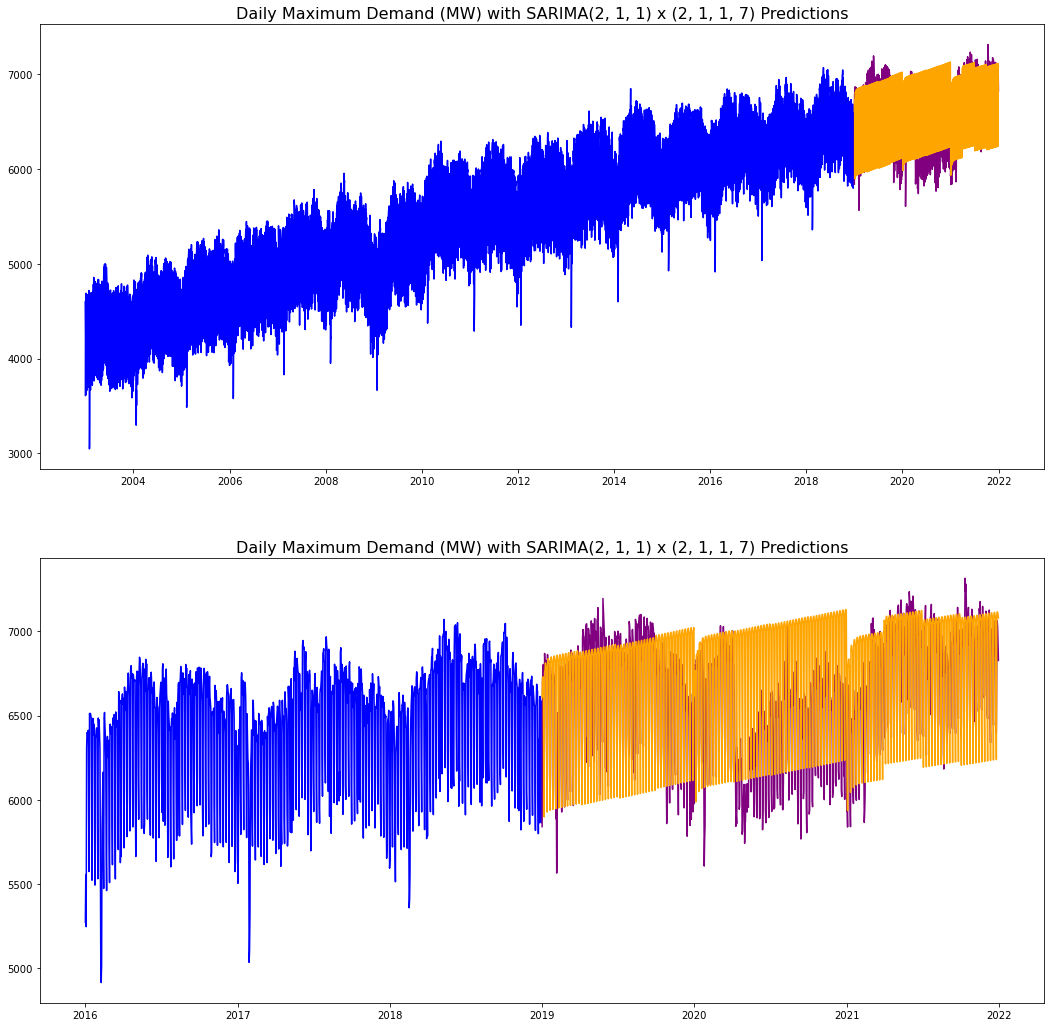

In [216]:
# fit sarimax with exogeneous predictor gdp (with 4Q-lag) 
fit_pred_visualise_sarimax(2, 1, 1, 2, 1, 1, 7, ['gdp_lag_4q'])

MSE: 184.38425630179063 (2019: 234.62724168734076; 2020: 53.425982857126655; 2021: 265.0995443609045)


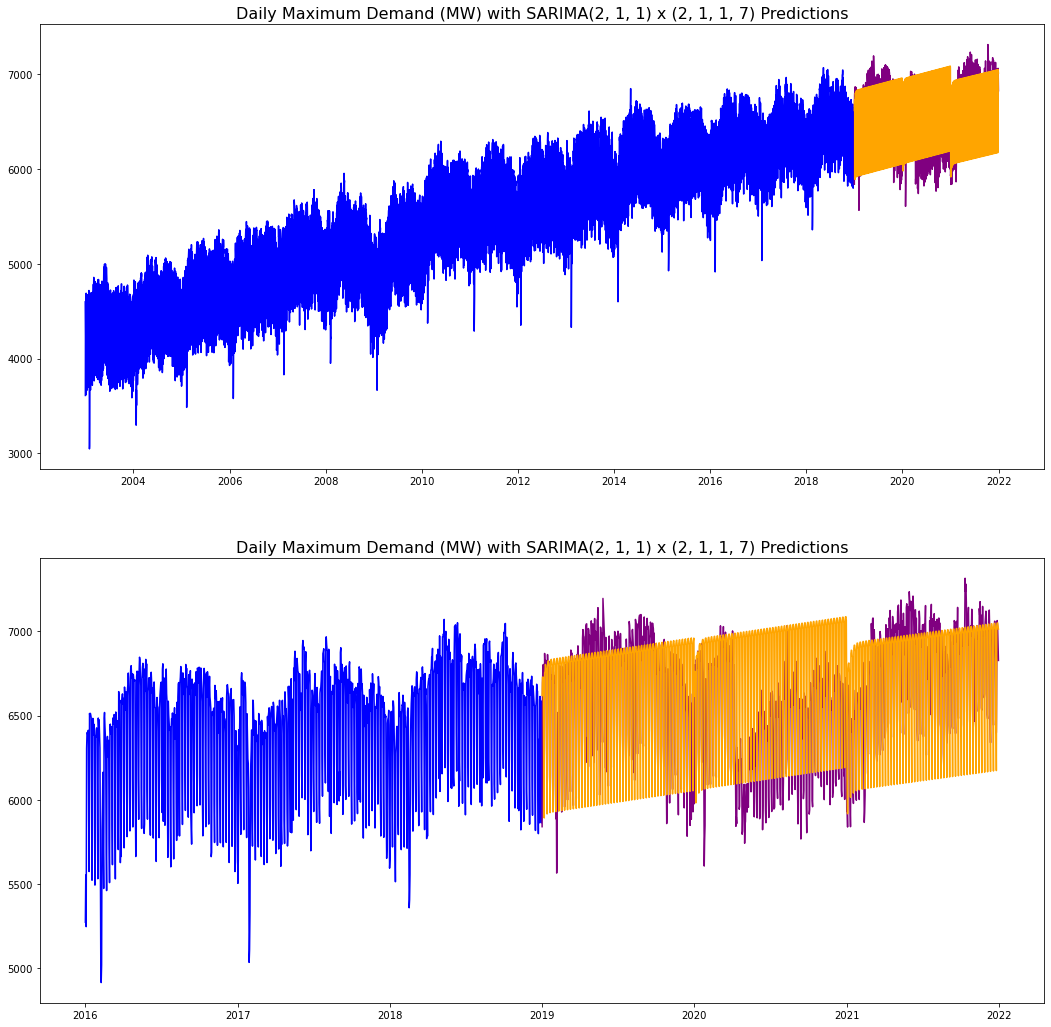

In [214]:
# fit sarimax with exogeneous predictors week
fit_pred_visualise_sarimax(2, 1, 1, 2, 1, 1, 7, [col for col in df if col.startswith('week')])

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MSE: 173.23520706385534 (2019: 149.9980225393947; 2020: 73.29858265633175; 2021: 296.4090159958396)


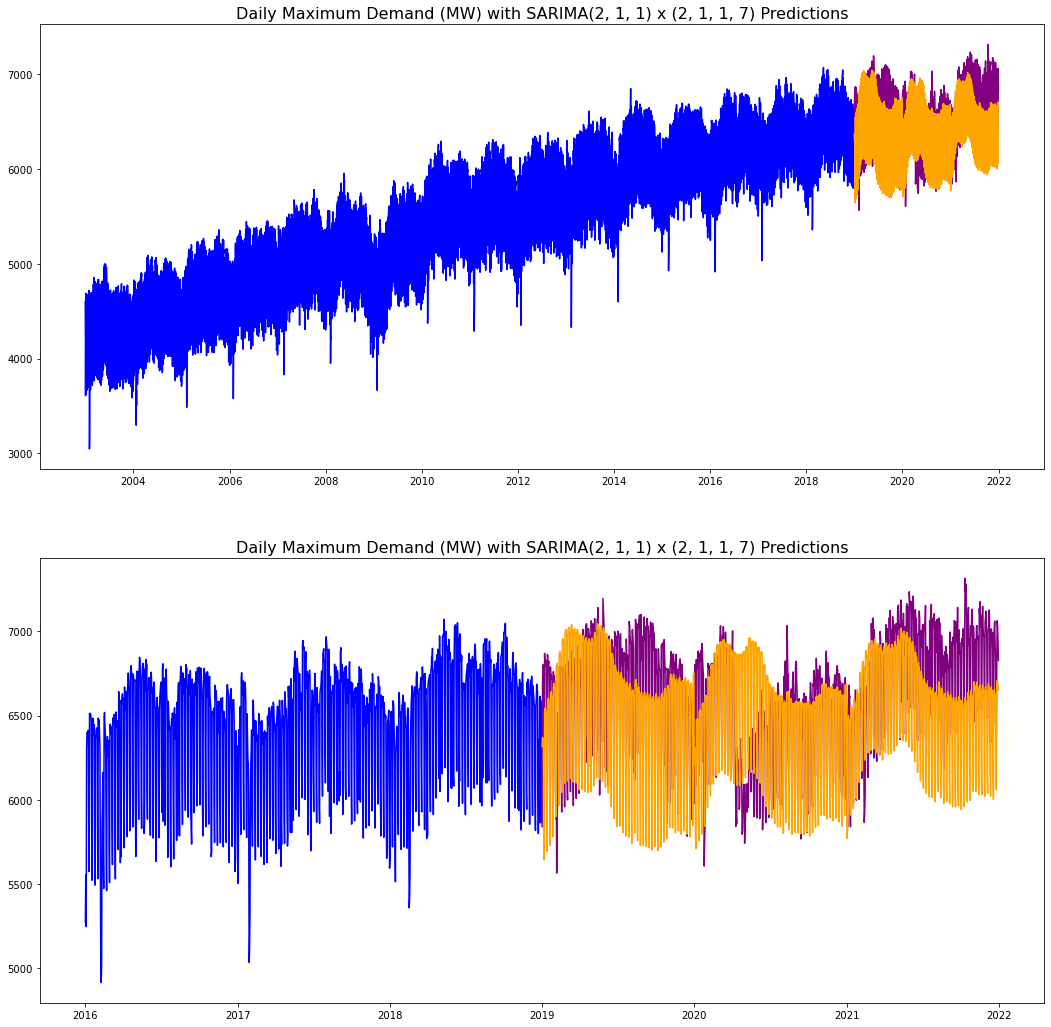

In [208]:
# fit sarimax with exogeneous predictors gdp (with 4Q-lag) and week
fit_pred_visualise_sarimax(2, 1, 1, 2, 1, 1, 7, ['gdp_lag_4q'] + [col for col in df if col.startswith('week')])

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MSE: 171.1677515005549 (2019: 151.04859542975555; 2020: 14.124576486548904; 2021: 348.3300825853603)


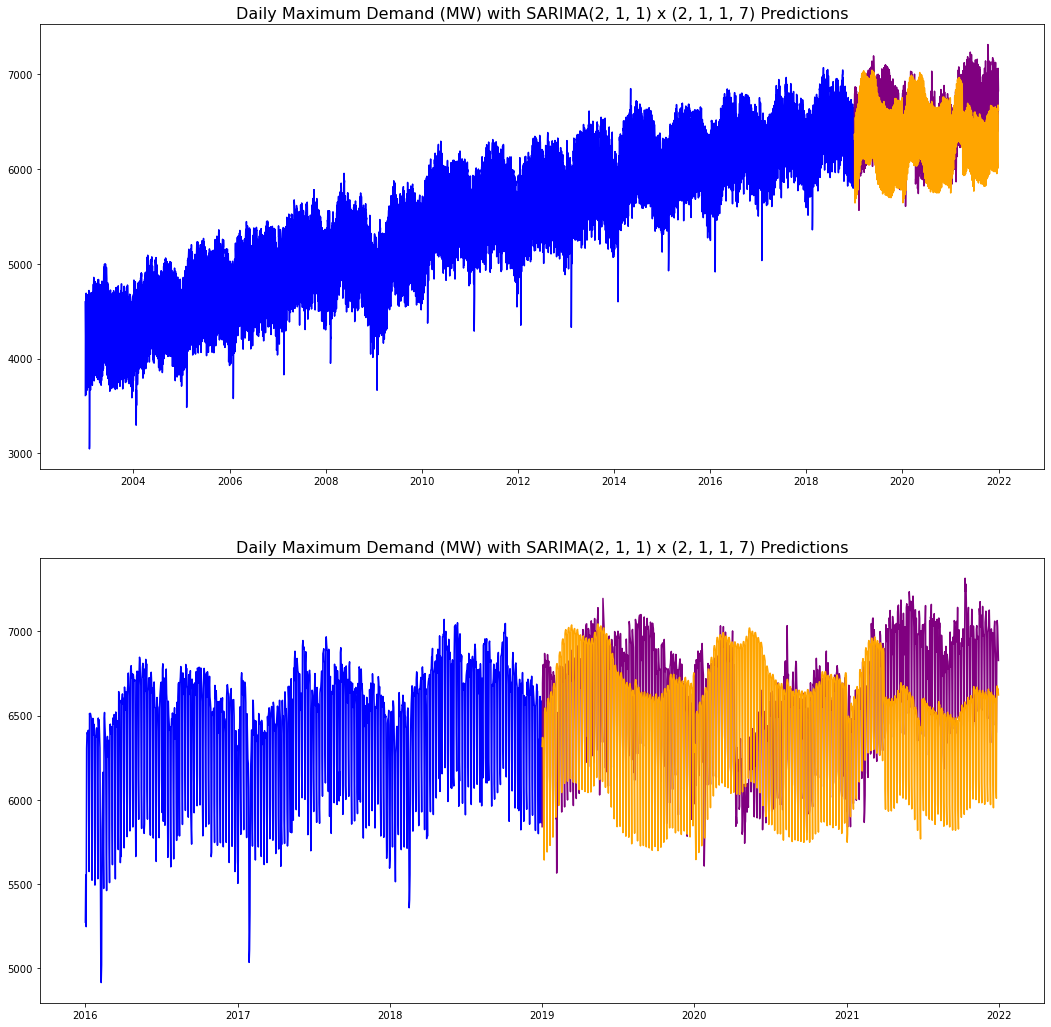

In [215]:
# fit sarimax with exogeneous predictors gdp (with 4Q-lag), week and dayofweek
fit_pred_visualise_sarimax(2, 1, 1, 2, 1, 1, 7, ['gdp_lag_4q'] + [col for col in df if col.startswith('week')] + [col for col in df if col.startswith('dayofweek_')])

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MSE: 197.5987296747262 (2019: 149.99418110307306; 2020: 69.19081315153835; 2021: 373.6111947695672)


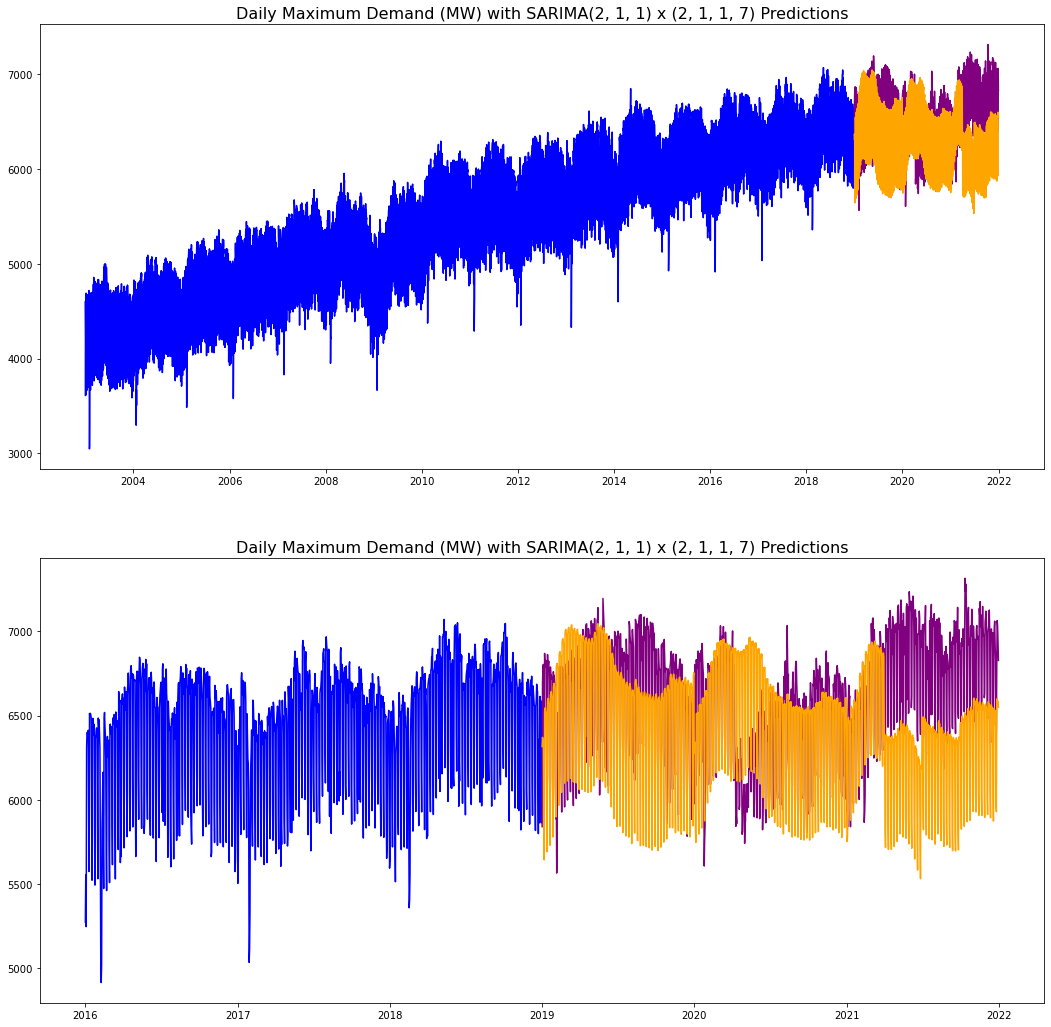

In [209]:
# fit sarimax with exogeneous predictors gdp (with 4Q-lag), week and weekday/weekend
fit_pred_visualise_sarimax(2, 1, 1, 2, 1, 1, 7, ['gdp_lag_4q'] + [col for col in df if col.startswith('week')] + ['is_weekday'])

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


MSE: 121.10239168854211 (2019: 149.98354510204445; 2020: 13.951021422890335; 2021: 199.37260854069154)


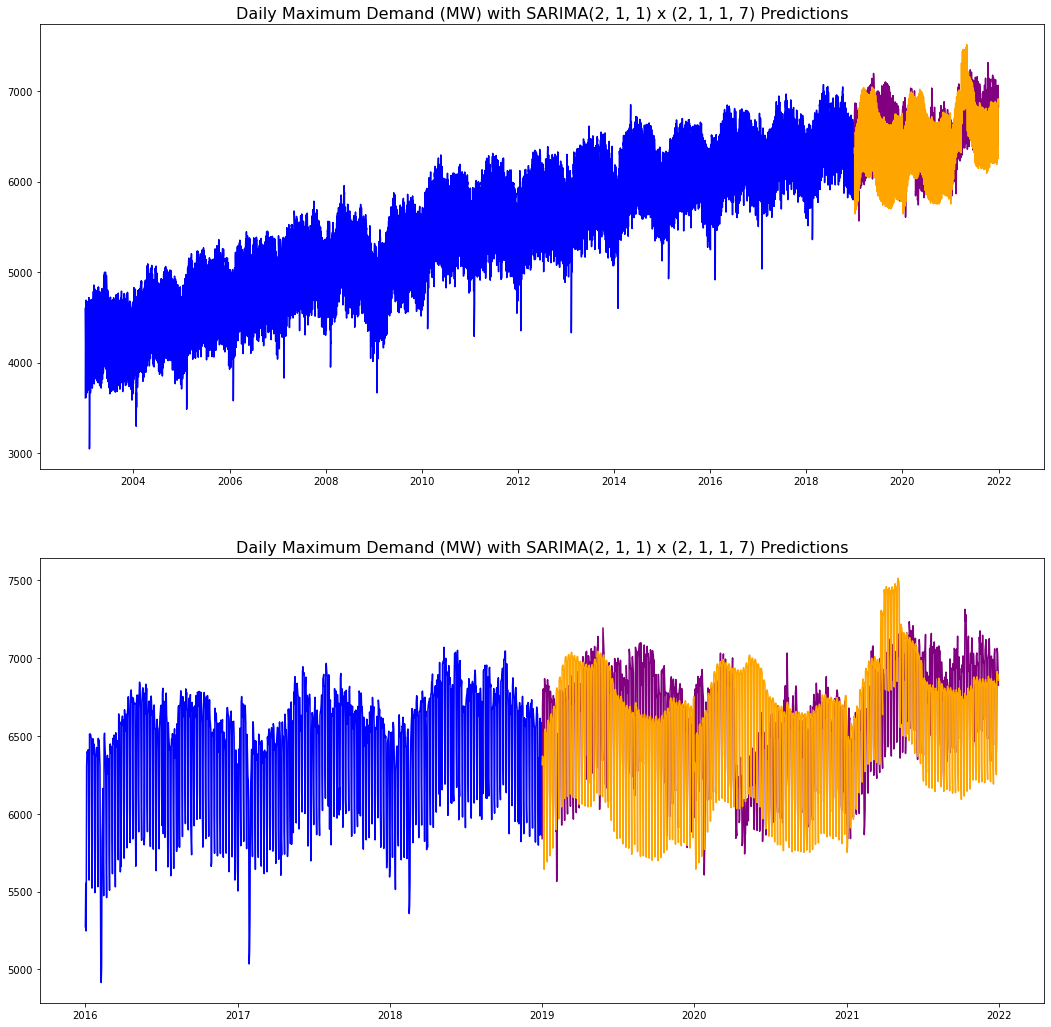

In [134]:
# fit sarimax with exogeneous predictors gdp (with 4Q-lag), week, dayofweek, and % wfh
fit_pred_visualise_sarimax(2, 1, 1, 2, 1, 1, 7, 
                           ['gdp_lag_4q'] + 
                           [col for col in df if col.startswith('week')] +
                           [col for col in df if col.startswith('dayofweek_')] + 
                           [col for col in df if col.startswith('wfh_indicator_')]
                          )

#### Performance of SARIMAX for different combination of exogenous predictors
|Model|Exogenous Predictors Tuned|Mean Error|Error for 2019|Error for 2020|Error for 2021|
|-----|----------|----------|-----------|--------------------|-----------|
|SARIMAX (2, 1, 1)x(2,1,1,7)| 1-year lag GDP|153.7|173.4|96.2|191.5|
|SARIMAX (2, 1, 1)x(2,1,1,7)| Week|184.4|234.6|53.4|265.1|
|SARIMAX (2, 1, 1)x(2,1,1,7)| 1-year lag GDP, Week|173.2|150.0|73.3|296.4|
|SARIMAX (2, 1, 1)x(2,1,1,7)| 1-year lag GDP, Week, Day of Week|171.2|151.0|14.1|348.3|
|SARIMAX (2, 1, 1)x(2,1,1,7)| 1-year lag GDP, Week, Is_Weekday|197.6|150.0|69.2|373.6|
|SARIMAX (2, 1, 1)x(2,1,1,7)| 1-year lag GDP, Week, Day of Week, % WFH|121.1|150.0|14.0|199.4|

- Based on the various combination of exogeneous variables with SARIMAX(2, 1, 1)x(2,1,1,7), we found that using the following 4 features resulted in the least error, i.e. 121 MW: 
    - 1-year lag GDP	
    - Week
    - Day of Week
    - % WFH due to COVID-19

#### Performance of the family of ARIMA models
|Model|Tuning parameters|Selected Model|Mean Error|
|-----|----------|----------|-----------|
|ARIMA| p = (0,1,..., 5); d = 1; q = (0,1,..., 5)|ARIMA (3,1,3)|444 MW|
|SARIMA| p = (0,1,2); d = 1; q = (0,1,2); P = (0,1,2); D = 1; Q = (0,1,2); S = 7|SARIMA (2, 1, 1)x(2,1,1,7)|190 MW|
|SARIMAX| 1-year lag GDP, Week, Day of Week, Is_weekday, % WFH|SARIMA (2, 1, 1)x(2,1,1,7) with 1-year lag GDP, Week, Day of Week, % WFH|121 MW|

- The table summarises the performance of the various arima models which were explored and the best performing model is SARIMAX with a mean error of 121 MW

# RNN

We also explored LSTM (long short term memory) RNN with recurive strategy (also known as "many-to-one" model) to predict demand. This strategy will do the following for train and test data:
- For train, take in the past 365 days (eg. 1 Jan to 31 Dec 2003) to predict the next day demand (e.g. 1 Jan 2004). Then shift the sliding window by a day and use 365 days again (e.g. 2 Jan 2003 to 1 Jan 2004) to predict the next day demand (e.g. 2 Jan 2004)
- For test, to predict demand for 2019, we use the historical data from 1 Jan - 31 Dec 2018 to predict the next day demand (1 Jan 2019). Then, we shift the sliding window by a day and use the actual demand from 2 Jan to 31 Dec 2018 and the predicted demand for 1 Jan 2019 to predict the next day demand (e.g. 2 Jan's 2019), and so on until we predicted the 365th day

In [137]:
# create a function to train-test split data
def traintestsplitXy(df, features, target, starting_year_test):
    X_train = df.loc[df['year'] < starting_year_test, features]
    X_test = df.loc[(df['year'] == starting_year_test) | (df['year'] == starting_year_test-1), features]
    y_train = df.loc[df['year'] < starting_year_test, target]
    y_test = df.loc[(df['year'] == starting_year_test) | (df['year'] == starting_year_test-1), target]
    return X_train, X_test, y_train, y_test

In [138]:
# create 3 train-test-split datasets for 2019, 2020 and 2021 respectively
features = ['demand_mw'] + ['gdp_lag_4q'] + [col for col in df if col.startswith('dayofweek_')] + [col for col in df if col.startswith('wfh_indicator_')] + [col for col in df if col.startswith('week')]
# features = [col for col in df.columns if not col == 'demand_mw']
X_train2021, X_test2021, y_train2021, y_test2021 = traintestsplitXy(df, features, ['demand_mw'], 2021)
X_train2020, X_test2020, y_train2020, y_test2020 = traintestsplitXy(df, features, ['demand_mw'], 2020)
X_train2019, X_test2019, y_train2019, y_test2019 = traintestsplitXy(df, features, ['demand_mw'], 2019)
print(X_train2021.shape, X_test2021.shape)
print(y_train2021.shape, y_test2021.shape)

(6575, 65) (731, 65)
(6575, 1) (731, 1)


In [139]:
# create a function to min-max-scale X_train and X_test datasets

def minmaxscalex(X_train, X_test):
    ssx = MinMaxScaler(feature_range=(0,1))
    X_train_ssx = ssx.fit_transform(X_train)
    X_test_ssx = ssx.transform(X_test)
    return ssx, X_train_ssx, X_test_ssx

ssx2021, X_train_ssx2021, X_test_ssx2021 = minmaxscalex(X_train2021, X_test2021)
ssx2020, X_train_ssx2020, X_test_ssx2020 = minmaxscalex(X_train2020, X_test2020)
ssx2019, X_train_ssx2019, X_test_ssx2019 = minmaxscalex(X_train2019, X_test2019)
print(X_train_ssx2021.shape, X_test_ssx2021.shape)
print(X_train_ssx2020.shape, X_test_ssx2020.shape)
print(X_train_ssx2019.shape, X_test_ssx2019.shape)

(6575, 65) (731, 65)
(6209, 65) (731, 65)
(5844, 65) (730, 65)


In [140]:
# create a function to min-max-scale y_train and y_test datasets

def minmaxscaley(y_train, y_test):
    ssy = MinMaxScaler(feature_range=(0,1))
    y_train_ssy = ssy.fit_transform(y_train)
    y_test_ssy = ssy.transform(y_test)
    return ssy, y_train_ssy, y_test_ssy

ssy2021, y_train_ssy2021, y_test_ssy2021 = minmaxscaley(y_train2021, y_test2021)
ssy2020, y_train_ssy2020, y_test_ssy2020 = minmaxscaley(y_train2020, y_test2020)
ssy2019, y_train_ssy2019, y_test_ssy2019 = minmaxscaley(y_train2019, y_test2019)
print(y_train_ssy2021.shape, y_test_ssy2021.shape)
print(y_train_ssy2020.shape, y_test_ssy2020.shape)
print(y_train_ssy2019.shape, y_test_ssy2019.shape)

(6575, 1) (731, 1)
(6209, 1) (731, 1)
(5844, 1) (730, 1)


In [141]:
# Create dataset to be input into the RNN model. Input shape should be [samples, time steps, features].

def create_dataset(df: np.array, lag=1, target_index=0) -> tuple:
    n_features = df.shape[1]
    Xs, ys = [], []      
    for i in range(lag, len(df)):
        Xs.append(df[i-lag:i])
        ys.append(df[i][target_index])        
    Xs, ys = np.array(Xs), np.array(ys)
    
    # reshape input to be [samples, time steps, features]
    Xs = np.reshape(Xs, (Xs.shape[0], lag, n_features))
    return Xs, ys

# Number of lags (hours back) to use for models
lag = 365
Xs_train_ssx2021, ys_train_ssy2021 = create_dataset(X_train_ssx2021, lag)
Xs_train_ssx2020, ys_train_ssy2020 = create_dataset(X_train_ssx2020, lag)
Xs_train_ssx2019, ys_train_ssy2019 = create_dataset(X_train_ssx2019, lag)

print(Xs_train_ssx2021.shape, ys_train_ssy2021.shape)
print(Xs_train_ssx2020.shape, ys_train_ssy2020.shape)
print(Xs_train_ssx2019.shape, ys_train_ssy2019.shape)

(6210, 365, 65) (6210,)
(5844, 365, 65) (5844,)
(5479, 365, 65) (5479,)


In [142]:
def fit_lstm(Xs_train_ssx, ys_train_ssy):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(Xs_train_ssx.shape[1], Xs_train_ssx.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(Xs_train_ssx, ys_train_ssy, epochs=20, batch_size=32, verbose=1)
    return model

In [143]:
# create function to provide one-year ahead predictions with lstm for the 3 training datasets

def predictions_lstm(model, Xs_test_ssx, ssy):
    
    # Generate predictions based on training set.
    target_index=0
    forecast_len = Xs_test_ssx.shape[0]
    preds_ss = []
    for step in range(forecast_len):
        # training data for 1-step ahead prediction
        X = Xs_test_ssx[step]
        # 1-step ahead prediction
        one_step_pred = model.predict(np.array(X).reshape(1, X.shape[0], X.shape[1]))
        preds_ss.extend(one_step_pred.tolist()[0])
        # replace actual figure of next training data with predicted figure
        if step < forecast_len-1:
            Xs_test_ssx[step+1][lag-1][target_index] = one_step_pred
            X = Xs_test_ssx
    
    # inverse transform the predictions for that one year
    preds = ssy.inverse_transform(np.array(preds_ss).reshape(-1, 1))
    preds_df = pd.DataFrame(preds)
    
    return preds_df

In [154]:
# create functions to combine predictions across 3 test years
def combine_preds(preds_df2019, preds_df2020, preds_df2021):
    preds_df = pd.concat((preds_df2019, preds_df2020, preds_df2021), axis=0)
    preds_df.columns = ['demand_pred']
    index = df.loc[(df.index.year >= 2019) & (df.index.year <= 2021),].index
    preds_df.index = index
    return preds_df

In [145]:
# create functions to combine pred and actual and split into train and test
def combine_df(preds_df):
    final_df = pd.concat((df[features], preds_df), axis=1)
    final_train = final_df.loc[final_df.index.year < 2019, :]
    final_test = final_df.loc[(final_df.index.year >= 2019) & (final_df.index.year <= 2021), :]
    return final_df, final_train, final_test

In [146]:
# create functions to compute mse of peak demand for 3 one-year ahead predictions

def mse_lstm(final_test, year):
    err = abs(final_test[final_test.index.year == year]['demand_mw'].max() - final_test[final_test.index.year == year]['demand_pred'].max())
    return err

In [147]:
# Fit LSTM model
model2019 = fit_lstm(Xs_train_ssx2019, ys_train_ssy2019)
model2020 = fit_lstm(Xs_train_ssx2020, ys_train_ssy2020)
model2021 = fit_lstm(Xs_train_ssx2021, ys_train_ssy2021)

Epoch 1/20
172/172 [==============================] - 61s 355ms/step - loss: 0.0221
Epoch 2/20
172/172 [==============================] - 65s 377ms/step - loss: 0.0131
Epoch 3/20
172/172 [==============================] - 66s 384ms/step - loss: 0.0106
Epoch 4/20
172/172 [==============================] - 66s 385ms/step - loss: 0.0085
Epoch 5/20
172/172 [==============================] - 65s 380ms/step - loss: 0.0076
Epoch 6/20
172/172 [==============================] - 65s 377ms/step - loss: 0.0067
Epoch 7/20
172/172 [==============================] - 65s 378ms/step - loss: 0.0058
Epoch 8/20
172/172 [==============================] - 66s 385ms/step - loss: 0.0057
Epoch 9/20
172/172 [==============================] - 65s 376ms/step - loss: 0.0050
Epoch 10/20
172/172 [==============================] - 65s 375ms/step - loss: 0.0049
Epoch 11/20
172/172 [==============================] - 64s 374ms/step - loss: 0.0050
Epoch 12/20
172/172 [==============================] - 65s 378ms/step - lo

In [150]:
# Prepare test data using create_dataset()

lag = 365 
# 2020 has 366 days while 2021 only has 365 days 
# remove 1 Jan 2020 from X_test_ssx2021 as we only need 365 days (2 Jan - 31 Dec) in 2020 to predict 1 Jan 2021
Xs_test_ssx2021, ys_test_ssy2021 = create_dataset(X_test_ssx2021[1:], lag)
Xs_test_ssx2020, ys_test_ssy2020 = create_dataset(X_test_ssx2020, lag)
Xs_test_ssx2019, ys_test_ssy2019 = create_dataset(X_test_ssx2019, lag)

print(Xs_test_ssx2021.shape, ys_test_ssy2021.shape)
print(Xs_test_ssx2020.shape, ys_test_ssy2020.shape)
print(Xs_test_ssx2019.shape, ys_test_ssy2019.shape)

(365, 365, 65) (365,)
(366, 365, 65) (366,)
(365, 365, 65) (365,)


In [152]:
# Predict for 2019, 2020 and 2021 and combining the predictions with actual
preds_df2019 = predictions_lstm(model2019, Xs_test_ssx2019, ssy2019)
preds_df2020 = predictions_lstm(model2020, Xs_test_ssx2020, ssy2020)
preds_df2021 = predictions_lstm(model2021, Xs_test_ssx2021, ssy2021)
preds_df = combine_pred(preds_df2019, preds_df2020, preds_df2021)
final, final_train, final_test = combine_df(preds_df)

In [153]:
# Calculate mean error in testing data
mse = (mse_lstm(final_test, 2019) + mse_lstm(final_test, 2020) + mse_lstm(final_test, 2021))/3
print(f"MSE: {mse} (2019: {mse_lstm(final_test, 2019)}; 2020: {mse_lstm(final_test, 2020)}; 2021: {mse_lstm(final_test, 2021)})")

MSE: 317.90917299763413 (2019: 393.4406507097483; 2020: 193.18046267235331; 2021: 367.1064056108007)


In [88]:
# Build a simpler LSTM model
def fit_lstm_simple(Xs_train_ssx, ys_train_ssy):
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(Xs_train_ssx.shape[1], Xs_train_ssx.shape[2])))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(Xs_train_ssx, ys_train_ssy, epochs=20, batch_size=32, verbose=1)
    return model

In [89]:
# Fit LSTM simpler model
model2019_simple = fit_lstm_simple(Xs_train_ssx2019, ys_train_ssy2019)
model2020_simple = fit_lstm_simple(Xs_train_ssx2020, ys_train_ssy2020)
model2021_simple = fit_lstm_simple(Xs_train_ssx2021, ys_train_ssy2021)

Epoch 1/20
172/172 [==============================] - 124s 724ms/step - loss: 0.0157
Epoch 2/20
172/172 [==============================] - 146s 849ms/step - loss: 0.0032
Epoch 3/20
172/172 [==============================] - 139s 806ms/step - loss: 0.0028
Epoch 4/20
172/172 [==============================] - 136s 791ms/step - loss: 0.0026
Epoch 5/20
172/172 [==============================] - 143s 833ms/step - loss: 0.0025
Epoch 6/20
172/172 [==============================] - 141s 820ms/step - loss: 0.0025
Epoch 7/20
172/172 [==============================] - 144s 836ms/step - loss: 0.0024
Epoch 8/20
172/172 [==============================] - 145s 841ms/step - loss: 0.0025
Epoch 9/20
172/172 [==============================] - 141s 818ms/step - loss: 0.0023
Epoch 10/20
172/172 [==============================] - 141s 819ms/step - loss: 0.0022
Epoch 11/20
172/172 [==============================] - 129s 749ms/step - loss: 0.0022
Epoch 12/20
172/172 [==============================] - 140s 812

In [90]:
# Predict for 2019, 2020 and 2021 and combining the predictions with actual
preds_df2019_simple = predictions_lstm(model2019_simple, Xs_test_ssx2019, ssy2019)
preds_df2020_simple = predictions_lstm(model2020_simple, Xs_test_ssx2020, ssy2020)
preds_df2021_simple = predictions_lstm(model2021_simple, Xs_test_ssx2021, ssy2021)
preds_df_simple = combine_pred(preds_df2019_simple, preds_df2020_simple, preds_df2021_simple)
final_simple, final_train_simple, final_test_simple = combine_df(preds_df_simple)

In [93]:
# Calculate mean error in testing data for simpler model
mse = (mse_lstm(final_test_simple, 2019) + mse_lstm(final_test_simple, 2020) + mse_lstm(final_test_simple, 2021))/3
print(f"MSE: {mse} (2019: {mse_lstm(final_test_simple, 2019)}; 2020: {mse_lstm(final_test_simple, 2020)}; 2021: {mse_lstm(final_test_simple, 2021)})")

MSE: 212.36298589559374 (2019: 47.08952898311691; 2020: 578.2415280607929; 2021: 11.757900642871391)


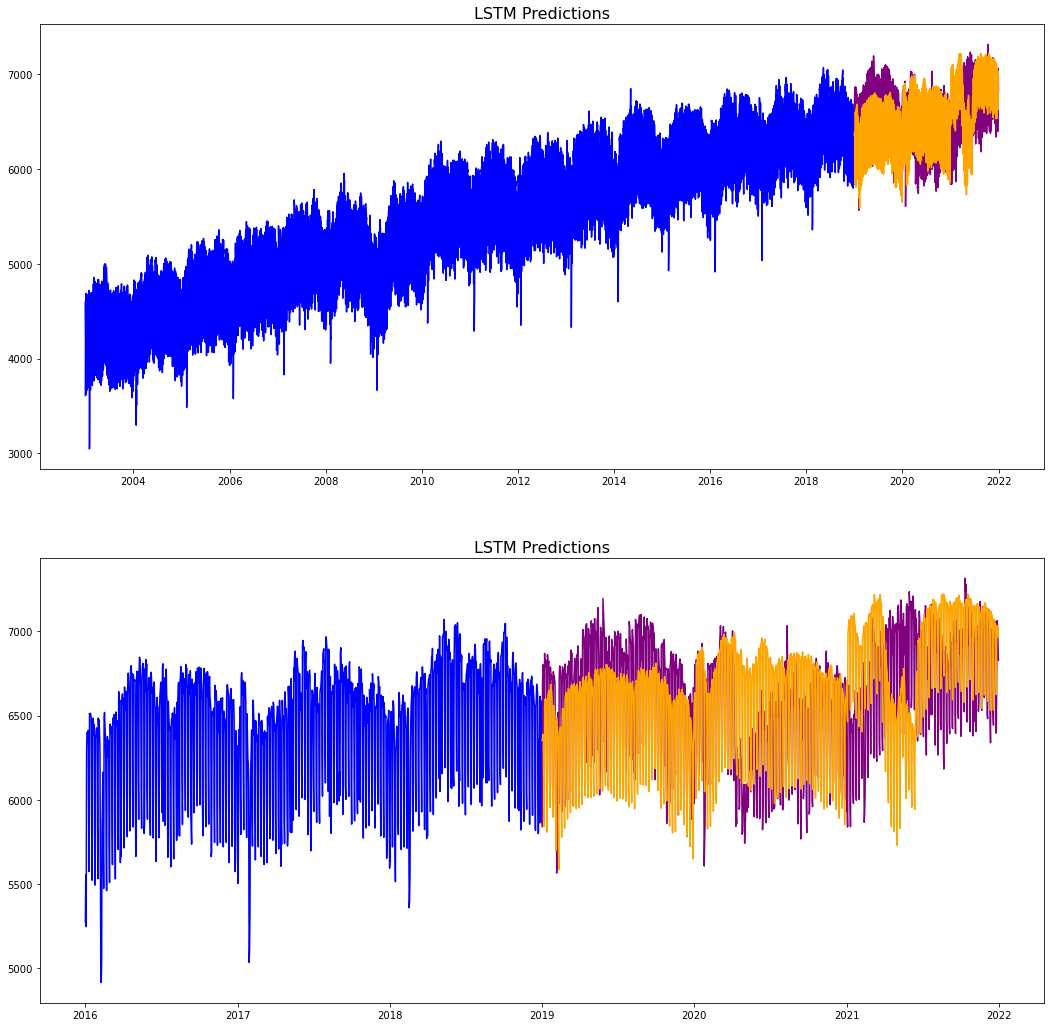

In [117]:
# Plot data for entire time horizon
plt.figure(figsize=(18, 18))

plt.subplot(2, 1, 1)
# Plot training data
plt.plot(final_train.index, final_train['demand_mw'], color = 'blue')
# Plot testing data
plt.plot(final_test.index, final_test['demand_mw'], color = 'purple')
# Plot predicted test values
plt.plot(final_test.index, final_test['demand_pred'], color = 'orange')
plt.title(label = 'LSTM Predictions', fontsize=16)

# Plot data for zoomed in time horizon from 2016
# Plot training data
plt.subplot(2, 1, 2)
plt.plot(final_train.index[4748:], final_train['demand_mw'][4748:], color = 'blue')
# Plot testing data
plt.plot(final_test.index, final_test['demand_mw'], color = 'purple')
# Plot predicted test values
plt.plot(final_test.index, final_test['demand_pred'], color = 'orange')
plt.title(label = 'LSTM Predictions', fontsize=16)
plt.show();

The mean error of LSTM RNN is about 173MW
- This mean error is lower than SARIMA but higher than SARIMAX
- That said, this model has yet to be tuned excessively, which could be why it does not outperform SARIMAX

In [130]:
#mse = (mse_lstm(2019) + mse_lstm(2020) + mse_lstm(2021))/3
#print(f"MSE: {mse} (2019: {mse_lstm(2019)}; 2020: {mse_lstm(2020)}; 2021: {mse_lstm(2021)})")

MSE: 172.7095731703248 (2019: 384.4215873966223; 2020: 40.54196982055964; 2021: 93.16516229379249)


# Final Model

For the final model, we chose SARIMAX considering its explanatory power, and further tune for p and q of the seasonal and non-seasonal component while fixing the 4 exogenous predictors (i.e. 1-year lag GDP, Week, Day of Week, % WFH)

In [248]:
# tune sarimax parameters - grid search for optimal p and q for non-seasonal component and P, D, Q of seasonal component
# based on selected exogeneous predictors - gdp (with 4Q-lag), week, dayofweek, and wfh indicator for COVID-19 period
list_of_exog = ['gdp_lag_4q'] + [col for col in df if col.startswith('dayofweek_')] + [col for col in df if col.startswith('wfh_indicator_')] + [col for col in df if col.startswith('week')]

# Starting MSE, (p, q) and (P, D, Q)
final_mse = 99 * (10 ** 16)
final_err2019 = 0
final_err2020 = 0
final_err2021 = 0
final_p = 0
final_q = 0
final_P = 0
final_D = 0
final_Q = 0

for p in range(3):
    for q in range(3):
        for P in range(3):
            for Q in range(3):
                for D in range(3):
                    try:

                        # Fitting an SARIMA(p, 1, q) model
                        print(f'Attempting SARIMAX({p}, 1, {q})x({P},{D},{Q},7)')

                        # Fit SARIMA model                        
                        model2019, model2020, model2021 = fit_sarimax(p, 1, q, P, D, Q, 7, list_of_exog)
                        
                        # Generate predictions based on training set
                        preds2019, preds2020, preds2021 = predictions_w_exog(model2019, model2020, model2021, list_of_exog)
                        
                        # Evaluate predictions
                        err2019, err2020, err2021, mse = mse_peak_testing(preds2019, preds2020, preds2021)
                        
                        print(f'The mean error for ({p}, 1, {q})x({P},{D},{Q},7) is: {mse}')
    
                        # Save for final report
                        if mse < final_mse:
                            final_mse = mse
                            final_err2019 = err2019
                            final_err2020 = err2020
                            final_err2021 = err2021
                            final_p = p
                            final_q = q
                            final_P = P
                            final_D = D
                            final_Q = Q

                    except:
                        pass
                    
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes mean error on the training data is the SARIMA({final_p}, 1, {final_q})x({final_P},{final_D},{final_Q},7).')
print(f'This model has a mean error of {final_mse} (2019: {err2019}; 2020: {err2020}; 2021: {err2021}).')

Attempting SARIMAX(0, 1, 0)x(0,0,0,7)
The mean error for (0, 1, 0)x(0,0,0,7) is: 490.01157357977746
Attempting SARIMAX(0, 1, 0)x(0,1,0,7)
The mean error for (0, 1, 0)x(0,1,0,7) is: 3745.534871542374
Attempting SARIMAX(0, 1, 0)x(0,2,0,7)
The mean error for (0, 1, 0)x(0,2,0,7) is: 236211.22892346955
Attempting SARIMAX(0, 1, 0)x(0,0,1,7)
The mean error for (0, 1, 0)x(0,0,1,7) is: 476.3406986021725
Attempting SARIMAX(0, 1, 0)x(0,1,1,7)
The mean error for (0, 1, 0)x(0,1,1,7) is: 344.0869467341742
Attempting SARIMAX(0, 1, 0)x(0,2,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The mean error for (0, 1, 0)x(0,2,1,7) is: 1659.3357502911313
Attempting SARIMAX(0, 1, 0)x(0,0,2,7)
The mean error for (0, 1, 0)x(0,0,2,7) is: 476.72864452248115
Attempting SARIMAX(0, 1, 0)x(0,1,2,7)
The mean error for (0, 1, 0)x(0,1,2,7) is: 220.54969107136154
Attempting SARIMAX(0, 1, 0)x(0,2,2,7)
The mean error for (0, 1, 0)x(0,2,2,7) is: 252.5690848368798
Attempting SARIMAX(0, 1, 0)x(1,0,0,7)
The mean error for (0, 1, 0)x(1,0,0,7) is: 476.50076666687954
Attempting SARIMAX(0, 1, 0)x(1,1,0,7)
The mean error for (0, 1, 0)x(1,1,0,7) is: 1122.517902737203
Attempting SARIMAX(0, 1, 0)x(1,2,0,7)
The mean error for (0, 1, 0)x(1,2,0,7) is: 123950.18990013708
Attempting SARIMAX(0, 1, 0)x(1,0,1,7)
The mean error for (0, 1, 0)x(1,0,1,7) is: 674.0429991865985
Attempting SARIMAX(0, 1, 0)x(1,1,1,7)
The mean error for (0, 1, 0)x(1,1,1,7) is: 179.65246165074313
Attempting SARIMAX(0, 1, 0)x(1,2,1,7)
The mean error for (0, 1, 0)x(1,2,1,7) is: 489.8255983594284
Attempting SARIMAX(0, 1, 0)x(1,0,2,7)
The 

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 0)x(1,1,2,7) is: 188.4081627508834
Attempting SARIMAX(0, 1, 0)x(1,2,2,7)
The mean error for (0, 1, 0)x(1,2,2,7) is: 313.9419765166949
Attempting SARIMAX(0, 1, 0)x(2,0,0,7)
The mean error for (0, 1, 0)x(2,0,0,7) is: 477.3239606532167
Attempting SARIMAX(0, 1, 0)x(2,1,0,7)
The mean error for (0, 1, 0)x(2,1,0,7) is: 395.5280324379543
Attempting SARIMAX(0, 1, 0)x(2,2,0,7)
The mean error for (0, 1, 0)x(2,2,0,7) is: 67508.69746414135
Attempting SARIMAX(0, 1, 0)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 0)x(2,0,1,7) is: 659.4621463095795
Attempting SARIMAX(0, 1, 0)x(2,1,1,7)
The mean error for (0, 1, 0)x(2,1,1,7) is: 180.7239986245777
Attempting SARIMAX(0, 1, 0)x(2,2,1,7)
The mean error for (0, 1, 0)x(2,2,1,7) is: 639.247170382711
Attempting SARIMAX(0, 1, 0)x(2,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 0)x(2,0,2,7) is: 659.8532602511514
Attempting SARIMAX(0, 1, 0)x(2,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 0)x(2,1,2,7) is: 180.10307606335695
Attempting SARIMAX(0, 1, 0)x(2,2,2,7)
The mean error for (0, 1, 0)x(2,2,2,7) is: 331.21302183641154
Attempting SARIMAX(0, 1, 1)x(0,0,0,7)
The mean error for (0, 1, 1)x(0,0,0,7) is: 317.1201217509976
Attempting SARIMAX(0, 1, 1)x(0,1,0,7)
The mean error for (0, 1, 1)x(0,1,0,7) is: 2192.1271176164905
Attempting SARIMAX(0, 1, 1)x(0,2,0,7)
The mean error for (0, 1, 1)x(0,2,0,7) is: 105245.94040323114
Attempting SARIMAX(0, 1, 1)x(0,0,1,7)
The mean error for (0, 1, 1)x(0,0,1,7) is: 372.4674617743858
Attempting SARIMAX(0, 1, 1)x(0,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 1)x(0,1,1,7) is: 139.4481685346303
Attempting SARIMAX(0, 1, 1)x(0,2,1,7)
The mean error for (0, 1, 1)x(0,2,1,7) is: 543.8988904718896
Attempting SARIMAX(0, 1, 1)x(0,0,2,7)
The mean error for (0, 1, 1)x(0,0,2,7) is: 381.648583051496
Attempting SARIMAX(0, 1, 1)x(0,1,2,7)
The mean error for (0, 1, 1)x(0,1,2,7) is: 98.9281313579504
Attempting SARIMAX(0, 1, 1)x(0,2,2,7)
The mean error for (0, 1, 1)x(0,2,2,7) is: 242.91005257897055
Attempting SARIMAX(0, 1, 1)x(1,0,0,7)
The mean error for (0, 1, 1)x(1,0,0,7) is: 402.5993139970548
Attempting SARIMAX(0, 1, 1)x(1,1,0,7)
The mean error for (0, 1, 1)x(1,1,0,7) is: 656.6549051437972
Attempting SARIMAX(0, 1, 1)x(1,2,0,7)
The mean error for (0, 1, 1)x(1,2,0,7) is: 83535.76383456441
Attempting SARIMAX(0, 1, 1)x(1,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 1)x(1,0,1,7) is: 525.494032718177
Attempting SARIMAX(0, 1, 1)x(1,1,1,7)
The mean error for (0, 1, 1)x(1,1,1,7) is: 97.93800107687123
Attempting SARIMAX(0, 1, 1)x(1,2,1,7)
The mean error for (0, 1, 1)x(1,2,1,7) is: 546.4761949949898
Attempting SARIMAX(0, 1, 1)x(1,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 1)x(1,0,2,7) is: 550.583319025638
Attempting SARIMAX(0, 1, 1)x(1,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 1)x(1,1,2,7) is: 78.47341134547696
Attempting SARIMAX(0, 1, 1)x(1,2,2,7)
The mean error for (0, 1, 1)x(1,2,2,7) is: 242.97414999599096
Attempting SARIMAX(0, 1, 1)x(2,0,0,7)
The mean error for (0, 1, 1)x(2,0,0,7) is: 381.42638227702355
Attempting SARIMAX(0, 1, 1)x(2,1,0,7)
The mean error for (0, 1, 1)x(2,1,0,7) is: 426.12224065666305
Attempting SARIMAX(0, 1, 1)x(2,2,0,7)
The mean error for (0, 1, 1)x(2,2,0,7) is: 50167.58566039903
Attempting SARIMAX(0, 1, 1)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 1)x(2,0,1,7) is: 584.6485112554041
Attempting SARIMAX(0, 1, 1)x(2,1,1,7)
The mean error for (0, 1, 1)x(2,1,1,7) is: 100.13361416711966
Attempting SARIMAX(0, 1, 1)x(2,2,1,7)
The mean error for (0, 1, 1)x(2,2,1,7) is: 628.6005990979838
Attempting SARIMAX(0, 1, 1)x(2,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 1)x(2,0,2,7) is: 557.1921340560617
Attempting SARIMAX(0, 1, 1)x(2,1,2,7)
The mean error for (0, 1, 1)x(2,1,2,7) is: 100.99955720907474
Attempting SARIMAX(0, 1, 1)x(2,2,2,7)
The mean error for (0, 1, 1)x(2,2,2,7) is: 254.68363691145169
Attempting SARIMAX(0, 1, 2)x(0,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(0,0,0,7) is: 340.51705865335344
Attempting SARIMAX(0, 1, 2)x(0,1,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(0,1,0,7) is: 106.48574873940652
Attempting SARIMAX(0, 1, 2)x(0,2,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(0,2,0,7) is: 2794.848020674814
Attempting SARIMAX(0, 1, 2)x(0,0,1,7)
The mean error for (0, 1, 2)x(0,0,1,7) is: 365.97769659508896
Attempting SARIMAX(0, 1, 2)x(0,1,1,7)
The mean error for (0, 1, 2)x(0,1,1,7) is: 104.96969627916769
Attempting SARIMAX(0, 1, 2)x(0,2,1,7)
The mean error for (0, 1, 2)x(0,2,1,7) is: 157.27055009260917
Attempting SARIMAX(0, 1, 2)x(0,0,2,7)
The mean error for (0, 1, 2)x(0,0,2,7) is: 410.5922892678973
Attempting SARIMAX(0, 1, 2)x(0,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(0,1,2,7) is: 104.92798875295193
Attempting SARIMAX(0, 1, 2)x(0,2,2,7)
The mean error for (0, 1, 2)x(0,2,2,7) is: 235.80788583133017
Attempting SARIMAX(0, 1, 2)x(1,0,0,7)
The mean error for (0, 1, 2)x(1,0,0,7) is: 410.16307092621565
Attempting SARIMAX(0, 1, 2)x(1,1,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(1,1,0,7) is: 358.54194312691317
Attempting SARIMAX(0, 1, 2)x(1,2,0,7)
The mean error for (0, 1, 2)x(1,2,0,7) is: 1555.7061273584804
Attempting SARIMAX(0, 1, 2)x(1,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(1,0,1,7) is: 423.5216377153832
Attempting SARIMAX(0, 1, 2)x(1,1,1,7)
The mean error for (0, 1, 2)x(1,1,1,7) is: 96.96339855917479
Attempting SARIMAX(0, 1, 2)x(1,2,1,7)
The mean error for (0, 1, 2)x(1,2,1,7) is: 594.1632686377401
Attempting SARIMAX(0, 1, 2)x(1,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(1,0,2,7) is: 424.61993222252505
Attempting SARIMAX(0, 1, 2)x(1,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(1,1,2,7) is: 129.37184558991703
Attempting SARIMAX(0, 1, 2)x(1,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(1,2,2,7) is: 245.57093075049215
Attempting SARIMAX(0, 1, 2)x(2,0,0,7)
The mean error for (0, 1, 2)x(2,0,0,7) is: 336.8108347150871
Attempting SARIMAX(0, 1, 2)x(2,1,0,7)
The mean error for (0, 1, 2)x(2,1,0,7) is: 495.5295022117116
Attempting SARIMAX(0, 1, 2)x(2,2,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(2,2,0,7) is: 292.1112730306747
Attempting SARIMAX(0, 1, 2)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(2,0,1,7) is: 414.903350983455
Attempting SARIMAX(0, 1, 2)x(2,1,1,7)
The mean error for (0, 1, 2)x(2,1,1,7) is: 100.67440883667253
Attempting SARIMAX(0, 1, 2)x(2,2,1,7)
The mean error for (0, 1, 2)x(2,2,1,7) is: 643.5104933245171
Attempting SARIMAX(0, 1, 2)x(2,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(2,0,2,7) is: 608.2646888345353
Attempting SARIMAX(0, 1, 2)x(2,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (0, 1, 2)x(2,1,2,7) is: 150.79150402046858
Attempting SARIMAX(0, 1, 2)x(2,2,2,7)
Attempting SARIMAX(1, 1, 0)x(0,0,0,7)
The mean error for (1, 1, 0)x(0,0,0,7) is: 451.91550890371764
Attempting SARIMAX(1, 1, 0)x(0,1,0,7)
The mean error for (1, 1, 0)x(0,1,0,7) is: 2654.522496276222
Attempting SARIMAX(1, 1, 0)x(0,2,0,7)
The mean error for (1, 1, 0)x(0,2,0,7) is: 154771.0516935375
Attempting SARIMAX(1, 1, 0)x(0,0,1,7)
The mean error for (1, 1, 0)x(0,0,1,7) is: 444.28509320628655
Attempting SARIMAX(1, 1, 0)x(0,1,1,7)
The mean error for (1, 1, 0)x(0,1,1,7) is: 119.16358523661681
Attempting SARIMAX(1, 1, 0)x(0,2,1,7)
The mean error for (1, 1, 0)x(0,2,1,7) is: 985.9131445347748
Attempting SARIMAX(1, 1, 0)x(0,0,2,7)
The mean error for (1, 1, 0)x(0,0,2,7) is: 444.3770741083754
Attempting SARIMAX(1, 1, 0)x(0,1,2,7)
The mean error for (1, 1, 0)x(0,1,2,7) is: 91.13282078179145
Attempting SARIMAX(1, 1, 0)x(0,2,2,7)
The mean error for (1, 1, 0)x(0,2,2,7) is: 1319.4017649091377
Attem

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 0)x(1,0,1,7) is: 538.4751047060023
Attempting SARIMAX(1, 1, 0)x(1,1,1,7)
The mean error for (1, 1, 0)x(1,1,1,7) is: 92.20333407848284
Attempting SARIMAX(1, 1, 0)x(1,2,1,7)
The mean error for (1, 1, 0)x(1,2,1,7) is: 516.2589787574349
Attempting SARIMAX(1, 1, 0)x(1,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 0)x(1,0,2,7) is: 608.1427771929539
Attempting SARIMAX(1, 1, 0)x(1,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 0)x(1,1,2,7) is: 147.39889527235755
Attempting SARIMAX(1, 1, 0)x(1,2,2,7)
The mean error for (1, 1, 0)x(1,2,2,7) is: 270.74059499529056
Attempting SARIMAX(1, 1, 0)x(2,0,0,7)
The mean error for (1, 1, 0)x(2,0,0,7) is: 444.5300649189403
Attempting SARIMAX(1, 1, 0)x(2,1,0,7)
The mean error for (1, 1, 0)x(2,1,0,7) is: 412.433117994308
Attempting SARIMAX(1, 1, 0)x(2,2,0,7)
The mean error for (1, 1, 0)x(2,2,0,7) is: 57561.11158954749
Attempting SARIMAX(1, 1, 0)x(2,0,1,7)
The mean error for (1, 1, 0)x(2,0,1,7) is: 533.8916723149614
Attempting SARIMAX(1, 1, 0)x(2,1,1,7)
The mean error for (1, 1, 0)x(2,1,1,7) is: 98.85356368332911
Attempting SARIMAX(1, 1, 0)x(2,2,1,7)
The mean error for (1, 1, 0)x(2,2,1,7) is: 637.839801309469
Attempting SARIMAX(1, 1, 0)x(2,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 0)x(2,0,2,7) is: 609.9130984196378
Attempting SARIMAX(1, 1, 0)x(2,1,2,7)
The mean error for (1, 1, 0)x(2,1,2,7) is: 85.70865661424887
Attempting SARIMAX(1, 1, 0)x(2,2,2,7)
The mean error for (1, 1, 0)x(2,2,2,7) is: 63303220873.873024
Attempting SARIMAX(1, 1, 1)x(0,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(0,0,0,7) is: 367.3414624135912
Attempting SARIMAX(1, 1, 1)x(0,1,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(0,1,0,7) is: 45.858808775714955
Attempting SARIMAX(1, 1, 1)x(0,2,0,7)
The mean error for (1, 1, 1)x(0,2,0,7) is: 1560.9425134963446
Attempting SARIMAX(1, 1, 1)x(0,0,1,7)
The mean error for (1, 1, 1)x(0,0,1,7) is: 428.3546344571038
Attempting SARIMAX(1, 1, 1)x(0,1,1,7)
The mean error for (1, 1, 1)x(0,1,1,7) is: 64.82731387401752
Attempting SARIMAX(1, 1, 1)x(0,2,1,7)
The mean error for (1, 1, 1)x(0,2,1,7) is: 156.7078732239661
Attempting SARIMAX(1, 1, 1)x(0,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(0,0,2,7) is: 372.7168664904436
Attempting SARIMAX(1, 1, 1)x(0,1,2,7)
The mean error for (1, 1, 1)x(0,1,2,7) is: 70.63735264732047
Attempting SARIMAX(1, 1, 1)x(0,2,2,7)
The mean error for (1, 1, 1)x(0,2,2,7) is: 263.1035388563226
Attempting SARIMAX(1, 1, 1)x(1,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(1,0,0,7) is: 347.46250617639515
Attempting SARIMAX(1, 1, 1)x(1,1,0,7)
The mean error for (1, 1, 1)x(1,1,0,7) is: 48.707135484227365
Attempting SARIMAX(1, 1, 1)x(1,2,0,7)
The mean error for (1, 1, 1)x(1,2,0,7) is: 329.0513716001503
Attempting SARIMAX(1, 1, 1)x(1,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(1,0,1,7) is: 419.714380115679
Attempting SARIMAX(1, 1, 1)x(1,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(1,1,1,7) is: 61.75175096236126
Attempting SARIMAX(1, 1, 1)x(1,2,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(1,2,1,7) is: 297.79228241871715
Attempting SARIMAX(1, 1, 1)x(1,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(1,0,2,7) is: 444.8709197680458
Attempting SARIMAX(1, 1, 1)x(1,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(1,1,2,7) is: 126.16080051563131
Attempting SARIMAX(1, 1, 1)x(1,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(1,2,2,7) is: 291.1560364451719
Attempting SARIMAX(1, 1, 1)x(2,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(2,0,0,7) is: 413.95009568651886
Attempting SARIMAX(1, 1, 1)x(2,1,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(2,1,0,7) is: 75.41732242456662
Attempting SARIMAX(1, 1, 1)x(2,2,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(2,2,0,7) is: 301.26702640211806
Attempting SARIMAX(1, 1, 1)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(2,0,1,7) is: 444.7472371456891
Attempting SARIMAX(1, 1, 1)x(2,1,1,7)
The mean error for (1, 1, 1)x(2,1,1,7) is: 70.46659107450735
Attempting SARIMAX(1, 1, 1)x(2,2,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(2,2,1,7) is: 292.11456313738046
Attempting SARIMAX(1, 1, 1)x(2,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(2,0,2,7) is: 635.2631124515198
Attempting SARIMAX(1, 1, 1)x(2,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 1)x(2,1,2,7) is: 120.76872437960112
Attempting SARIMAX(1, 1, 1)x(2,2,2,7)
The mean error for (1, 1, 1)x(2,2,2,7) is: 245.7960182156788
Attempting SARIMAX(1, 1, 2)x(0,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(0,0,0,7) is: 421.5050020188867
Attempting SARIMAX(1, 1, 2)x(0,1,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(0,1,0,7) is: 58.34710145861997
Attempting SARIMAX(1, 1, 2)x(0,2,0,7)
The mean error for (1, 1, 2)x(0,2,0,7) is: 1819.791427304247
Attempting SARIMAX(1, 1, 2)x(0,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(0,0,1,7) is: 431.90052047690307
Attempting SARIMAX(1, 1, 2)x(0,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(0,1,1,7) is: 37.980755222783955
Attempting SARIMAX(1, 1, 2)x(0,2,1,7)
The mean error for (1, 1, 2)x(0,2,1,7) is: 163.60048968974115
Attempting SARIMAX(1, 1, 2)x(0,0,2,7)
The mean error for (1, 1, 2)x(0,0,2,7) is: 433.0838055627337
Attempting SARIMAX(1, 1, 2)x(0,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(0,1,2,7) is: 23.958825358399128
Attempting SARIMAX(1, 1, 2)x(0,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(0,2,2,7) is: 280.9689364141338
Attempting SARIMAX(1, 1, 2)x(1,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(1,0,0,7) is: 408.7534889840863
Attempting SARIMAX(1, 1, 2)x(1,1,0,7)
The mean error for (1, 1, 2)x(1,1,0,7) is: 51.496745351865684
Attempting SARIMAX(1, 1, 2)x(1,2,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(1,2,0,7) is: 316.0461842942559
Attempting SARIMAX(1, 1, 2)x(1,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(1,0,1,7) is: 630.2268774138929
Attempting SARIMAX(1, 1, 2)x(1,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(1,1,1,7) is: 84.68209521521628
Attempting SARIMAX(1, 1, 2)x(1,2,1,7)
Attempting SARIMAX(1, 1, 2)x(1,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(1,0,2,7) is: 612.9530237355654
Attempting SARIMAX(1, 1, 2)x(1,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(1,1,2,7) is: 108.24833272972712
Attempting SARIMAX(1, 1, 2)x(1,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(1,2,2,7) is: 4497552330.866925
Attempting SARIMAX(1, 1, 2)x(2,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(2,0,0,7) is: 431.7273829011656
Attempting SARIMAX(1, 1, 2)x(2,1,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(2,1,0,7) is: 79.97430079415001
Attempting SARIMAX(1, 1, 2)x(2,2,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(2,2,0,7) is: 418.11650157351477
Attempting SARIMAX(1, 1, 2)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(2,0,1,7) is: 543.75493942165
Attempting SARIMAX(1, 1, 2)x(2,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(2,1,1,7) is: 46.347175862916025
Attempting SARIMAX(1, 1, 2)x(2,2,1,7)
Attempting SARIMAX(1, 1, 2)x(2,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(2,0,2,7) is: 650.6098748046252
Attempting SARIMAX(1, 1, 2)x(2,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (1, 1, 2)x(2,1,2,7) is: 110.14365391581123
Attempting SARIMAX(1, 1, 2)x(2,2,2,7)
Attempting SARIMAX(2, 1, 0)x(0,0,0,7)
The mean error for (2, 1, 0)x(0,0,0,7) is: 422.74779462135
Attempting SARIMAX(2, 1, 0)x(0,1,0,7)
The mean error for (2, 1, 0)x(0,1,0,7) is: 2344.900698708306
Attempting SARIMAX(2, 1, 0)x(0,2,0,7)
The mean error for (2, 1, 0)x(0,2,0,7) is: 125800.27787898555
Attempting SARIMAX(2, 1, 0)x(0,0,1,7)
The mean error for (2, 1, 0)x(0,0,1,7) is: 416.5855176020198
Attempting SARIMAX(2, 1, 0)x(0,1,1,7)
The mean error for (2, 1, 0)x(0,1,1,7) is: 108.24422513960205
Attempting SARIMAX(2, 1, 0)x(0,2,1,7)
The mean error for (2, 1, 0)x(0,2,1,7) is: 763.4151343721436
Attempting SARIMAX(2, 1, 0)x(0,0,2,7)
The mean error for (2, 1, 0)x(0,0,2,7) is: 416.5560297518832
Attempting SARIMAX(2, 1, 0)x(0,1,2,7)
The mean error for (2, 1, 0)x(0,1,2,7) is: 105.35392880951046
Attempting SARIMAX(2, 1, 0)x(0,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 0)x(0,2,2,7) is: 272.83384861629867
Attempting SARIMAX(2, 1, 0)x(1,0,0,7)
The mean error for (2, 1, 0)x(1,0,0,7) is: 416.45465210993035
Attempting SARIMAX(2, 1, 0)x(1,1,0,7)
The mean error for (2, 1, 0)x(1,1,0,7) is: 973.2138160588196
Attempting SARIMAX(2, 1, 0)x(1,2,0,7)
The mean error for (2, 1, 0)x(1,2,0,7) is: 90616.15042027169
Attempting SARIMAX(2, 1, 0)x(1,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 0)x(1,0,1,7) is: 594.6553536325051
Attempting SARIMAX(2, 1, 0)x(1,1,1,7)
The mean error for (2, 1, 0)x(1,1,1,7) is: 111.44846538788472
Attempting SARIMAX(2, 1, 0)x(1,2,1,7)
The mean error for (2, 1, 0)x(1,2,1,7) is: 508.7430163438369
Attempting SARIMAX(2, 1, 0)x(1,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 0)x(1,0,2,7) is: 592.7945558586401
Attempting SARIMAX(2, 1, 0)x(1,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 0)x(1,1,2,7) is: 105.44593526563888
Attempting SARIMAX(2, 1, 0)x(1,2,2,7)
The mean error for (2, 1, 0)x(1,2,2,7) is: 280.9587031084193
Attempting SARIMAX(2, 1, 0)x(2,0,0,7)
The mean error for (2, 1, 0)x(2,0,0,7) is: 416.3915760269253
Attempting SARIMAX(2, 1, 0)x(2,1,0,7)
The mean error for (2, 1, 0)x(2,1,0,7) is: 391.32882433543153
Attempting SARIMAX(2, 1, 0)x(2,2,0,7)
The mean error for (2, 1, 0)x(2,2,0,7) is: 55739.05611554329
Attempting SARIMAX(2, 1, 0)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 0)x(2,0,1,7) is: 592.4358259975467
Attempting SARIMAX(2, 1, 0)x(2,1,1,7)
The mean error for (2, 1, 0)x(2,1,1,7) is: 143.39175899359302
Attempting SARIMAX(2, 1, 0)x(2,2,1,7)
The mean error for (2, 1, 0)x(2,2,1,7) is: 626.2088466798629
Attempting SARIMAX(2, 1, 0)x(2,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 0)x(2,0,2,7) is: 593.6615440949539
Attempting SARIMAX(2, 1, 0)x(2,1,2,7)
The mean error for (2, 1, 0)x(2,1,2,7) is: 102.52635264223652
Attempting SARIMAX(2, 1, 0)x(2,2,2,7)
The mean error for (2, 1, 0)x(2,2,2,7) is: 289.16961845694914
Attempting SARIMAX(2, 1, 1)x(0,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(0,0,0,7) is: 391.48112304174145
Attempting SARIMAX(2, 1, 1)x(0,1,0,7)
The mean error for (2, 1, 1)x(0,1,0,7) is: 59.74002680672917
Attempting SARIMAX(2, 1, 1)x(0,2,0,7)
The mean error for (2, 1, 1)x(0,2,0,7) is: 2109.3493007629218
Attempting SARIMAX(2, 1, 1)x(0,0,1,7)
The mean error for (2, 1, 1)x(0,0,1,7) is: 392.0397677799244
Attempting SARIMAX(2, 1, 1)x(0,1,1,7)
The mean error for (2, 1, 1)x(0,1,1,7) is: 177.68408771505983
Attempting SARIMAX(2, 1, 1)x(0,2,1,7)
The mean error for (2, 1, 1)x(0,2,1,7) is: 379.2552975950809
Attempting SARIMAX(2, 1, 1)x(0,0,2,7)
The mean error for (2, 1, 1)x(0,0,2,7) is: 435.7639343124617
Attempting SARIMAX(2, 1, 1)x(0,1,2,7)
The mean error for (2, 1, 1)x(0,1,2,7) is: 63.63533488666053
Attempting SARIMAX(2, 1, 1)x(0,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Attempting SARIMAX(2, 1, 1)x(1,0,0,7)
The mean error for (2, 1, 1)x(1,0,0,7) is: 435.6677951238753
Attempting SARIMAX(2, 1, 1)x(1,1,0,7)
The mean error for (2, 1, 1)x(1,1,0,7) is: 49.292060157804976
Attempting SARIMAX(2, 1, 1)x(1,2,0,7)
The mean error for (2, 1, 1)x(1,2,0,7) is: 349.62312112121225
Attempting SARIMAX(2, 1, 1)x(1,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(1,0,1,7) is: 551.386297880815
Attempting SARIMAX(2, 1, 1)x(1,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(1,1,1,7) is: 123.7745584543821
Attempting SARIMAX(2, 1, 1)x(1,2,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(1,2,1,7) is: 9481058306966.928
Attempting SARIMAX(2, 1, 1)x(1,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(1,0,2,7) is: 543.6466776907542
Attempting SARIMAX(2, 1, 1)x(1,1,2,7)
The mean error for (2, 1, 1)x(1,1,2,7) is: 106.32800506743722
Attempting SARIMAX(2, 1, 1)x(1,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(1,2,2,7) is: 6121878225.006618
Attempting SARIMAX(2, 1, 1)x(2,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(2,0,0,7) is: 435.15289448569274
Attempting SARIMAX(2, 1, 1)x(2,1,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(2,1,0,7) is: 81.61199800444956
Attempting SARIMAX(2, 1, 1)x(2,2,0,7)
The mean error for (2, 1, 1)x(2,2,0,7) is: 494.3484817138269
Attempting SARIMAX(2, 1, 1)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(2,0,1,7) is: 539.1559125977795
Attempting SARIMAX(2, 1, 1)x(2,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(2,1,1,7) is: 121.53949140397101
Attempting SARIMAX(2, 1, 1)x(2,2,1,7)
The mean error for (2, 1, 1)x(2,2,1,7) is: 82407.79934524295
Attempting SARIMAX(2, 1, 1)x(2,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(2,0,2,7) is: 648.1021613569234
Attempting SARIMAX(2, 1, 1)x(2,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(2,1,2,7) is: 109.03783515509167
Attempting SARIMAX(2, 1, 1)x(2,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 1)x(2,2,2,7) is: 191129512086.4325
Attempting SARIMAX(2, 1, 2)x(0,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(0,0,0,7) is: 419.9279309050953
Attempting SARIMAX(2, 1, 2)x(0,1,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(0,1,0,7) is: 62.17404284040216
Attempting SARIMAX(2, 1, 2)x(0,2,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(0,2,0,7) is: 2235.8348005341013
Attempting SARIMAX(2, 1, 2)x(0,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(0,0,1,7) is: 430.8774016731959
Attempting SARIMAX(2, 1, 2)x(0,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(0,1,1,7) is: 115.84756900328709
Attempting SARIMAX(2, 1, 2)x(0,2,1,7)
The mean error for (2, 1, 2)x(0,2,1,7) is: 160.03910678321822
Attempting SARIMAX(2, 1, 2)x(0,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(0,0,2,7) is: 430.4605759940135
Attempting SARIMAX(2, 1, 2)x(0,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(0,1,2,7) is: 61.45926712109849
Attempting SARIMAX(2, 1, 2)x(0,2,2,7)
The mean error for (2, 1, 2)x(0,2,2,7) is: 3.2687377109361996e+16
Attempting SARIMAX(2, 1, 2)x(1,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(1,0,0,7) is: 428.4275618599859
Attempting SARIMAX(2, 1, 2)x(1,1,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(1,1,0,7) is: 66.21982359585066
Attempting SARIMAX(2, 1, 2)x(1,2,0,7)
The mean error for (2, 1, 2)x(1,2,0,7) is: 387.4834480489705
Attempting SARIMAX(2, 1, 2)x(1,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(1,0,1,7) is: 503.84817702892906
Attempting SARIMAX(2, 1, 2)x(1,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(1,1,1,7) is: 61.845509924033344
Attempting SARIMAX(2, 1, 2)x(1,2,1,7)
The mean error for (2, 1, 2)x(1,2,1,7) is: 157.16273535625865
Attempting SARIMAX(2, 1, 2)x(1,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(1,0,2,7) is: 446.794006064141
Attempting SARIMAX(2, 1, 2)x(1,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(1,1,2,7) is: 118.71284690383406
Attempting SARIMAX(2, 1, 2)x(1,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(1,2,2,7) is: 262.4023955372668
Attempting SARIMAX(2, 1, 2)x(2,0,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(2,0,0,7) is: 430.23638163183085
Attempting SARIMAX(2, 1, 2)x(2,1,0,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(2,1,0,7) is: 44.18905316156148
Attempting SARIMAX(2, 1, 2)x(2,2,0,7)
The mean error for (2, 1, 2)x(2,2,0,7) is: 508.359080315707
Attempting SARIMAX(2, 1, 2)x(2,0,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(2,0,1,7) is: 428.6444728392398
Attempting SARIMAX(2, 1, 2)x(2,1,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(2,1,1,7) is: 100.76729055887488
Attempting SARIMAX(2, 1, 2)x(2,2,1,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(2,2,1,7) is: 427.31767348415934
Attempting SARIMAX(2, 1, 2)x(2,0,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(2,0,2,7) is: 633.5783481178156
Attempting SARIMAX(2, 1, 2)x(2,1,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


The mean error for (2, 1, 2)x(2,1,2,7) is: 88.44845824195545
Attempting SARIMAX(2, 1, 2)x(2,2,2,7)


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)




MODEL FINISHED!
Our model that minimizes mean error on the training data is the SARIMA(1, 1, 2)x(0,1,2,7).
This model has a mean error of 23.958825358399128 (2019: 163.05985222599975; 2020: 69.83379968723966; 2021: 32.45172281262694).


C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWar

MSE: 23.958825358399128 (2019: 33.132618170457135; 2020: 1.7156169914969723; 2021: 37.02824091324328)


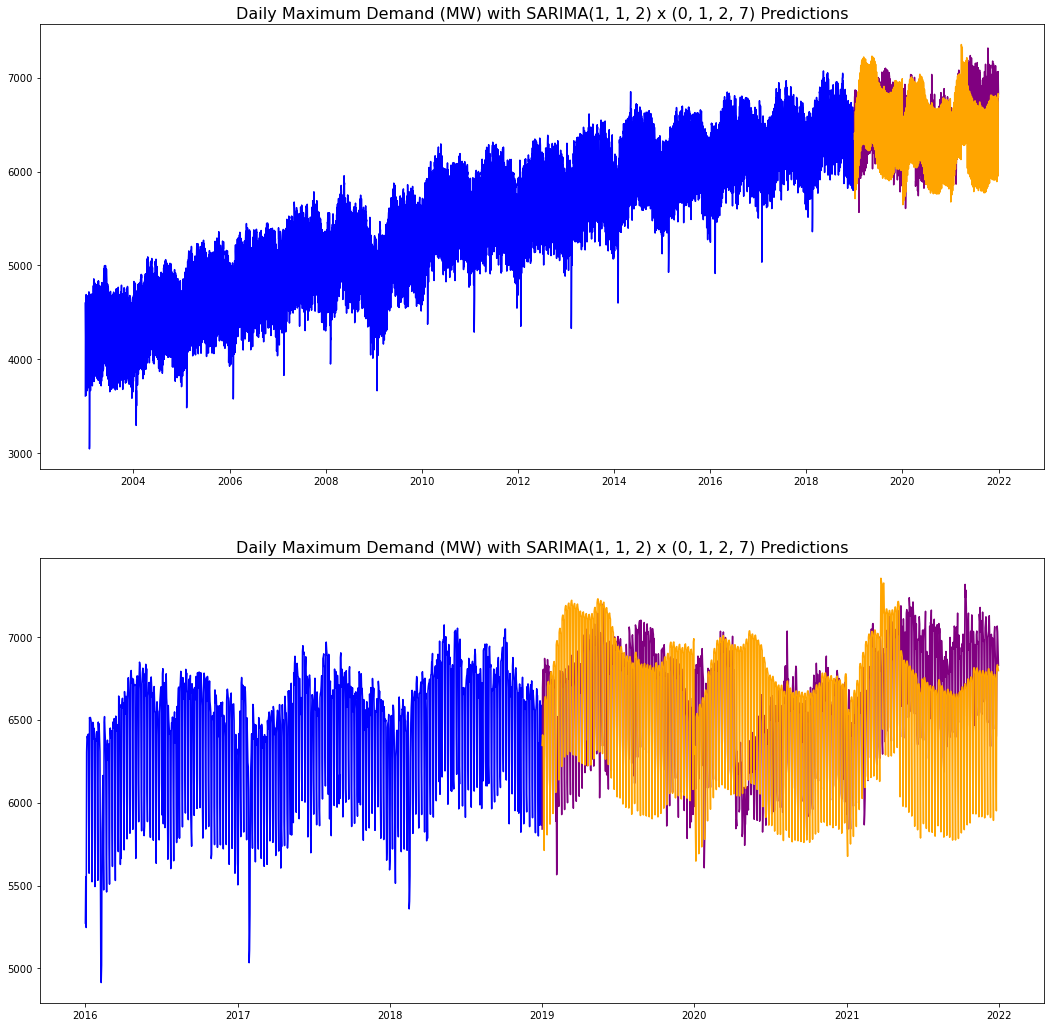

In [254]:
fit_pred_visualise_sarimax(1, 1, 2, 0, 1, 2, 7, list_of_exog)

- The final model SARIMAX(1, 1, 2)x(0, 1, 2, 7) with the 4 exogenous predictors (i.e. 1-year lag GDP, Week, Day of Week, % WFH) yield a mean error of 24 MW
- From the chart, we can see that the predicted peak demand are close to the actual peak demand for 2019, 2020 and 2021

# Prediction

The last thing we do here is to predict the peak demand for 2022 based on the final model selected and using train data from 2003-2021

In [584]:
# Prepare 'test' data for 2022 predictions
pred_X = pd.DataFrame()

# create a list of dates in 2022
start = datetime.datetime.strptime("01-01-2022", "%m-%d-%Y")
date_generated = pd.date_range(start, periods=365)
pred_X['date'] = date_generated.strftime("%m-%d-%Y")

# convert date to datetime format
pred_X['date'] = pd.to_datetime(pred_X['date'])

# create dayofweek to indicate the day of week
pred_X['dayofweek'] = pred_X['date'].apply(lambda date: date.weekday())
pred_X['dayofweek'] = pred_X['dayofweek'].apply(lambda day: weekdays[day])

# create year and quarter columns in pred_X data as well for merging of datasets
pred_X['year'] = pred_X['date'].dt.year
pred_X['quarter'] = pred_X['date'].dt.quarter

# merge pred_X with gdp data
pred_X = pd.merge(left = pred_X, 
         right = gdp, 
         how = "left",
         left_on = ['year', 'quarter'],
        right_on = ['year', 'quarter'])

# merge pred_X with covid data
pred_X = pd.merge(left = pred_X, 
         right = covid, 
         how = "left",
         left_on = ['date_x'],
        right_on = ['date'])

# Set index to be the date column as a DatetimeIndex
pred_X.set_index(pred_X['date'], inplace=True)

# create a column to indicate week
pred_X['week'] = pred_X.index.strftime('%U')
pred_X['week'] = pred_X['week'].astype(str)

# convert wfh_indicator to str
pred_X['wfh_indicator'] = pred_X['wfh_indicator'].astype(str)
# pred_X.loc[pred_X['wfh_indicator'] == '0','wfh_indicator'] = '25'

In [586]:
# Non-numeric features
non_numeric_features = [
    'week',
    'dayofweek',
    'wfh_indicator'
]

# Create a new dataframe to hold dummies for all categorical features
dummies_pred_X = pred_X[non_numeric_features]
dummies_pred_X = pd.get_dummies(dummies_pred_X, drop_first=True)
pred_X.drop(columns=['week'], inplace = True)

# Create a new dataframe to hold wfh_indicator
# dummies_wfh = pred_X[['wfh_indicator']]
# dummies_wfh = pd.get_dummies(dummies_wfh, drop_first=False)

# Add on the dummified week to pred_X 
pred_X = pd.concat(objs = [pred_X, dummies_pred_X], axis = 1)

# Drop date columns and other columns which we will not be using
pred_X.drop(columns=['date_x', 'date_y', 'dayofweek', 'year', 'quarter', 'gdp', 'date',
                   'day_type', 'holiday', 'covid_phase', 'wfh_indicator'], 
          inplace=True)

In [588]:
# Further edit the columns to align with exogenous predictors used in SARIMAX

# create columns on wfh_indicator_100.0 and wfh_indicator_75.0
pred_X['wfh_indicator_100.0'] = 0
pred_X['wfh_indicator_75.0'] = 0
pred_X = pred_X.rename(columns={"wfh_indicator_25": "wfh_indicator_25.0", "wfh_indicator_50": "wfh_indicator_50.0"})

# create columns on week_53
pred_X['week_53'] = 0

In [591]:
# Use all data from 2003-2021 to predict 2022's peak demand
final_df = df[['demand_mw'] + list_of_exog]

# Instantiate SARIMA model
final_sarimax = SARIMAX(endog = final_df.loc[final_df.index.year <= 2021, 'demand_mw'],
                 order = (1, 1, 2),              # (p, d, q)
                 seasonal_order = (0, 1, 2, 7), # (P, D, Q, S)
                exog = final_df.loc[final_df.index.year <= 2021, list_of_exog])

# Fit SARIMAX(1, 1, 2) x (0, 1, 2, 7) with exogeneous predictors
final_model = final_sarimax.fit()

# Generate predictions based on training set
preds2022 = final_model.predict(
    start=pred_X.index[0], 
    end = pred_X.index[-1], 
    exog=pred_X[list_of_exog],
    )

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [592]:
# Predicted peak demand for 2022
preds2022.max()

7751.525860826843

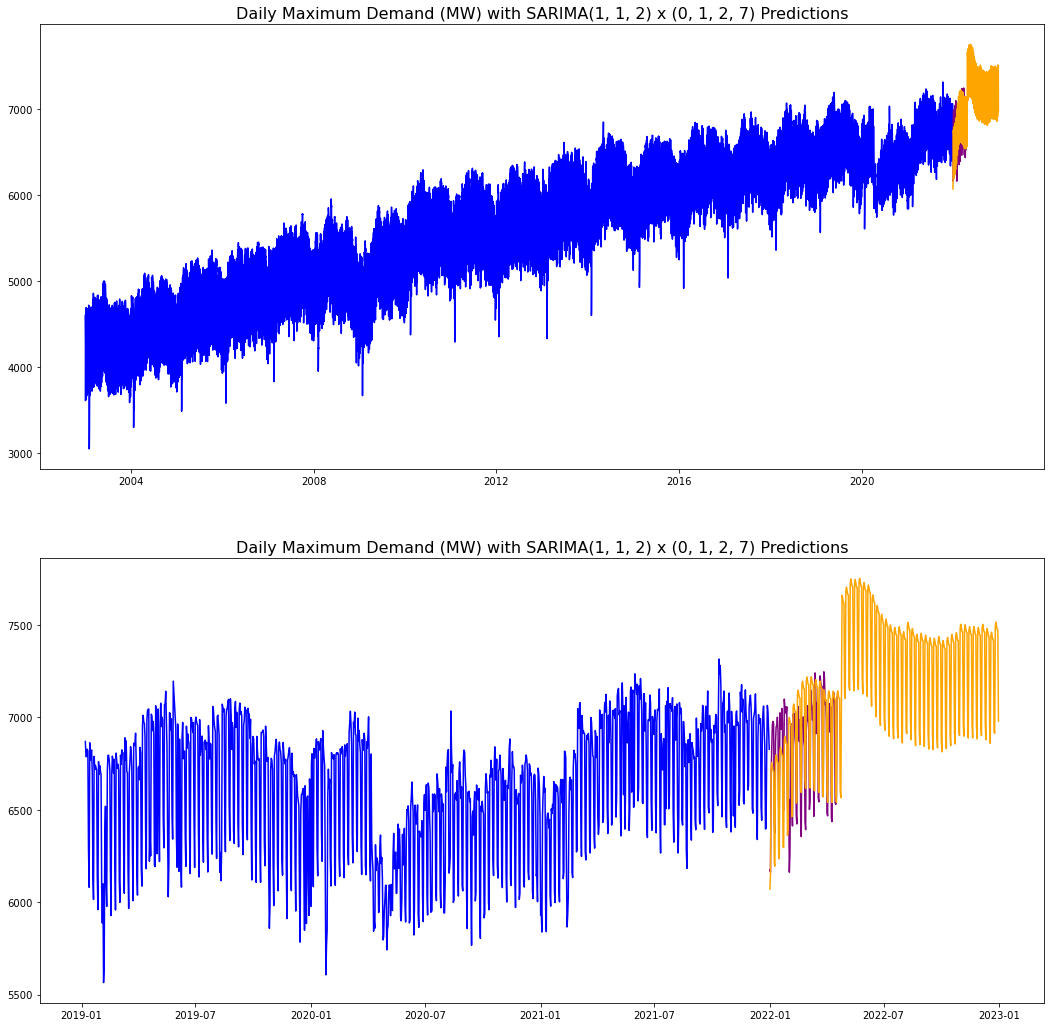

In [595]:
# Plot data for entire time horizon
plt.figure(figsize=(18, 18))

plt.subplot(2, 1, 1)
# Plot training data
plt.plot(final_df.loc[final_df.index.year <= 2021, 'demand_mw'].index, final_df.loc[final_df.index.year <= 2021, 'demand_mw'], color = 'blue')
# Plot actual 2022 data from 1 Jan - 18 Apr 2022
plt.plot(final_df.loc[final_df.index.year == 2022, 'demand_mw'].index, final_df.loc[final_df.index.year == 2022, 'demand_mw'], color = 'purple')
# Plot predicted test values
plt.plot(pred_X.index, preds2022, color = 'orange')
plt.title(label = f"Daily Maximum Demand (MW) with SARIMA(1, 1, 2) x (0, 1, 2, 7) Predictions", fontsize=16)

# Plot data for zoomed in time horizon from 2016
# Plot training data
plt.subplot(2, 1, 2)
plt.plot(final_df.loc[final_df.index.year <= 2021, 'demand_mw'].index[5850:], final_df.loc[final_df.index.year <= 2021, 'demand_mw'][5850:], color = 'blue')
# Plot testing data
plt.plot(final_df.loc[final_df.index.year == 2022, 'demand_mw'].index, final_df.loc[final_df.index.year == 2022, 'demand_mw'], color = 'purple')
# Plot predicted test values
plt.plot(pred_X.index, preds2022, color = 'orange')
plt.title(label = f"Daily Maximum Demand (MW) with SARIMA(1, 1, 2) x (0, 1, 2, 7) Predictions", fontsize=16)
plt.show();

- Based on our final model, the predicted peak demand for 2022 is 7,751 MW
- Based on the chart, we observe that the predicted demand (in orange) is quite close to the actual demand from 1 Jan to 18 Apr 2022 (in purple) which was not used for prediction. There is a spike in predicted demand in Apr due to further easing of COVID measures from 26 Apr
- While we do not expect the actual demand to spike on 26 Apr, we expect the peak demand to reach ~7,750 MW in the later part of the year (similar to the predictions vs actual in the train-test data)

# Next Steps

- Feature Engineering
    - Incorporate public holidays considering that demand is affected by whether it is a working day or not
    - Since day and week are important features, transform them to sin and cos functions to better model their cyclical patterns
- Model
    - Increasing testing period to 5 years (instead of 3) to see if the model performs consistently well. We start off with 3 years for now because we do not have many years of historical data
    - Exploration: 
        - Further tune the LSTM RNN model
        - Multiple output strategy (one ‘many-to-many’ architecture) for RNN e.g. using 365 days to predict 365 days ahead simultaneously (instead of sliding windows)^
        - GRU, CNN, etc.
- Application
    - Predict total annual demand which will be useful for computing electricity tariff
    - Predict peak demand/total annual demand for a longer forecast period e.g. 10 years